In [18]:
# !pip install -U yt-dlp==2023.1.6 matplotlib==3.6.0 datasets[audio] rich

# install newest transformers build to be able to pass `inputs_embeds` through generate()
# !pip install --upgrade git+https://github.com/huggingface/transformers.git

**Relevant huggingface gpt2 code**

- https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
- https://github.com/huggingface/transformers/blob/main/src/transformers/generation/utils.py
- https://github.com/huggingface/transformers/issues/6535
- bos/eos discussion: https://github.com/huggingface/transformers/issues/3311

**Todo**

- Rerun embedding generation for musiccaps/make sure it's the same as jamendo and none of the changes in mtg_jam.. broke it (forward hook should use input or output correctly)
- embedding concat vs sum vs mean
- metrics (with different generation methods/args)
- tokenization might still be a problem

# Load musiccaps

In [1]:
from musiccaps import load_musiccaps
import numpy as np
from rich import print as printr
from torch.utils.data import DataLoader, Dataset, random_split
import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import itertools
import math
from rich import print as printr
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from pathlib import Path
import json
import random
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def filter_muscaps_with_embeddings(ds, embeddings):
    '''Some clips weren't downloaded so we couldn't embed them, get rid of that'''
    exclude_ids = set()
    for i in range(len(ds)):
        if ds[i]['ytid'] not in embeddings.keys():
            exclude_ids.add(i)
    ds = ds.select(
        (
            i for i in range(len(ds)) 
            if i not in set(exclude_ids)
        )
    )
    assert len(ds) == len(embeddings)
    return ds

In [3]:
ds = load_musiccaps(
    './music_data',
    sampling_rate=16000,
    limit=None,
    num_proc=8,
    writer_batch_size=1000,
    return_without_audio=True
)
embeddings = np.load('embeddings.npy', allow_pickle=True).item()

Using custom data configuration google--MusicCaps-7925612b943f961b
Found cached dataset csv (/home/dominik/.cache/huggingface/datasets/google___csv/google--MusicCaps-7925612b943f961b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


In [4]:
class CaptionEmbedding(Dataset):
    '''Returns a torch Dataset of paired captions and embeddings'''
    def __init__(self, muscaps_ds, embeddings):
        ds = filter_muscaps_with_embeddings(muscaps_ds, embeddings)
        self.captions = ds.sort(column='ytid')['caption']
        sorted_embs = [value for _, value in sorted(embeddings.items())]
        self.embeddings = torch.from_numpy(np.stack(sorted_embs)).to(device)

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        
        emb = self.embeddings[idx]
        assert len(emb) == 512
        emb = (emb[:256]+emb[256:])/2
        
        return self.captions[idx], emb

In [5]:
dataset = CaptionEmbedding(muscaps_ds=ds, embeddings=embeddings)
train_frac = 0.8
training_data, test_data = random_split(dataset, [train_frac, 1-train_frac])

# quick check did not mess up ordering of caption-embedding pairs
# for cap, emb in tqdm(dataset):
#     for i in range(len(ds)):
#         if cap == ds[i]['caption']:
#             assert torch.allclose(emb,torch.from_numpy(embeddings[ds[i]['ytid']]).to(device))

Parameter 'indices'=<generator object filter_muscaps_with_embeddings.<locals>.<genexpr> at 0x7f341e6fb5f0> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [6]:
# get a list of music-related words to use for evaluation
aspects = []
for x in ds:
    aspect_str = x['aspect_list']
    for t in ('[]"\''):
        aspect_str = aspect_str.replace(t, '')
    aspects.extend(aspect_str.split(', '))
    
from collections import Counter
# only pick aspects that show up somewhat frequently
aspects = {s for s, count in Counter(aspects).most_common() if count >= 25}
len(aspects)

378

# Load Jamendo tag/embedding dataset

In [7]:
JAMENDO_TAGS = np.array(['genre---alternative','genre---ambient','genre---atmospheric','genre---chillout','genre---classical','genre---dance','genre---downtempo','genre---easylistening','genre---electronic','genre---experimental','genre---folk','genre---funk','genre---hiphop','genre---house','genre---indie','genre---instrumentalpop','genre---jazz','genre---lounge','genre---metal','genre---newage','genre---orchestral','genre---pop','genre---popfolk','genre---poprock','genre---reggae','genre---rock','genre---soundtrack','genre---techno','genre---trance','genre---triphop','genre---world','instrument---acousticguitar','instrument---bass','instrument---computer','instrument---drummachine','instrument---drums','instrument---electricguitar','instrument---electricpiano','instrument---guitar','instrument---keyboard','instrument---piano','instrument---strings','instrument---synthesizer','instrument---violin','instrument---voice','mood/theme---emotional','mood/theme---energetic','mood/theme---film','mood/theme---happy','mood/theme---relaxing'])

def get_top_tags(scores, k=3, threshold=.4):
    assert scores.shape == (2, 50)
    scores = (scores[0]+scores[1])/2
    indices = np.where(scores>threshold)[0]
    sorted_indices = indices[np.argsort(-scores[indices])[:k]]
    return JAMENDO_TAGS[sorted_indices]

In [8]:
jam_tags = {}
jam_pred_tags = {}
jam_embeddings = {}
jam_scores = {}

jam_embeddings_dir = Path('./jam_embeddings')

for i in range(100):
    try:
        with open(jam_embeddings_dir / f'tags_{i:02d}.json') as f:
            jam_tags.update(json.load(f))
    except Exception as e:
        print(e)
        continue
    data_dict = np.load(jam_embeddings_dir / f'embeddings_{i:02d}.npy', allow_pickle=True)
    jam_embeddings.update(data_dict.item())
    data_dict = np.load(jam_embeddings_dir / f'tag_scores_{i:02d}.npy', allow_pickle=True)
    jam_scores.update(data_dict.item())
    
for k, v in jam_scores.items():
    jam_pred_tags[k] = get_top_tags(v, k=3, threshold=0.4)
    
pred_tag_counts = np.array([len(v) for v in jam_pred_tags.values()])
print(f'avg number of pred tags = {(pred_tag_counts).mean()}, fraction of samples with 0 pred tags = {(pred_tag_counts==0).mean()}')

[Errno 2] No such file or directory: 'jam_embeddings/tags_35.json'
avg number of pred tags = 1.1215934627170583, fraction of samples with 0 pred tags = 0.21151453245426688


In [9]:
pred_tag_counts = np.array([len(v) for v in jam_tags.values()])
print(f'avg number of jamendo tags = {(pred_tag_counts).mean()}, fraction of samples with 0 jamendo tags = {(pred_tag_counts==0).mean()}')

avg number of jamendo tags = 4.659095552047543, fraction of samples with 0 jamendo tags = 0.0


In [10]:
for x in list(jam_tags.keys())[:15]:
    print(jam_tags[x])
    print(jam_pred_tags[x])
    print()

['genre---progressiverock', 'genre---rock', 'genre---rocknroll']
['genre---rock']

['genre---progressiverock', 'genre---rock', 'genre---rocknroll']
['genre---rock']

['genre---progressiverock', 'genre---rock', 'genre---rocknroll']
['genre---rock']

['genre---progressiverock', 'genre---rock', 'genre---rocknroll']
['genre---rock' 'instrument---drums']

['genre---progressiverock', 'genre---rock', 'genre---rocknroll']
['genre---rock' 'instrument---drums' 'instrument---bass']

['genre---classicrock', 'genre---hardrock', 'genre---rocknroll']
['genre---rock']

['genre---classicrock', 'genre---hardrock', 'genre---rocknroll']
['genre---rock']

['genre---classicrock', 'genre---hardrock', 'genre---rocknroll']
['genre---rock']

['genre---classicrock', 'genre---hardrock', 'genre---rocknroll']
['genre---rock']

['genre---classicrock', 'genre---hardrock', 'genre---rocknroll']
['genre---rock']

['genre---electronic']
['genre---electronic' 'genre---dance']

['genre---electronic']
['genre---electronic']

In [11]:
class JamendoTagDataset(Dataset):
    def __init__(self, jam_tags, jam_pred_tags, jam_embeddings):
        
        self.keys = sorted(jam_tags.keys())
        self.jam_tags = jam_tags
        self.jam_pred_tags = jam_pred_tags
        self.jam_embeddings = jam_embeddings

    def __len__(self):
        return len(self.jam_tags)

    def __getitem__(self, idx):
        id = self.keys[idx]
        
        tags = self.jam_tags[id]
        categories = defaultdict(set)
        for t in tags:
            assert '---' in t
            categories[t[:t.find('---')]].add(t[t.find('---')+3:])
            
        result = []
        for k in sorted(categories.keys()):
            cat_tags = list(categories[k])
            result.append(k + ': ' + ', '.join(random.sample(cat_tags, len(cat_tags))))
        tags_cap = '; '.join(result)
            
        #tags = [t.replace('---', ': ') for t in tags]
        #tags = [t[t.find('---')+3:] if '---' in t else t for t in tags]
        #random.shuffle(tags)
        #tags_cap = ', '.join(tags)
        
        emb = self.jam_embeddings[id]
        assert emb.shape == (2, 256)
        emb = (emb[0]+emb[1])/2
        
        return tags_cap, torch.from_numpy(emb).to(device)

In [12]:
jam_dataset = JamendoTagDataset(jam_tags, jam_pred_tags, jam_embeddings)
train_frac = 0.8
training_data, test_data = random_split(jam_dataset, [train_frac, 1-train_frac])

# Training

### Tokenization

target should be:

`"<pad> caption <eos> <mask...>"` (first element is dropped in transformer.forward)

input should be:

`"<music-emb> caption <eos> <pad...>"`

where

- `<bos>` = `<eos>` (for gpt2, see https://github.com/huggingface/transformers/issues/2026)
- `<mask>` is -100 (masked in cross-entropy, see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- `<pad>` is arbitrary
- `<music-emb>` is the encoded music

In [13]:
class ResidualLinear(nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, dim)
        
    def forward(self, x):
        return x + self.fc(torch.nn.functional.relu(x))

class B2T(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Linear(256, 768),
            nn.ReLU(),
            nn.Linear(768, 768),
            nn.ReLU(),
            nn.Linear(768, 768),
        )
        
    def forward(self, x):
        return self.main(x)

In [14]:
def tokenize(captions_batch):
    input_ids = tokenizer(captions_batch)['input_ids']
    
     # wrap in eos and add placeholder for music embedding/mask
    input_ids = [torch.tensor([eos_id, placeholder_id] + x + [eos_id]) for x in input_ids]
    # pad with -100, this index is masked in the cross-entropy loss
    input_ids_target = torch.nn.utils.rnn.pad_sequence(
        input_ids,
        batch_first=True,
        padding_value=mask_id
    ).to(device)
    
    # index -100 isn't valid as model input however, since the token embedding lookup fails
    # so we need a second version as model input, with -100 replaced with another token (shouldn't matter which)
    input_ids = input_ids_target.clone()
    input_ids[input_ids==mask_id] = eos_id
    
    return input_ids, input_ids_target

In [15]:
def transform_input_ids(music_embedding, input_ids, input_ids_target):
    music_emb_ind = 1
    assert (input_ids[:, music_emb_ind]==placeholder_id).all()
    assert (input_ids_target[:, music_emb_ind]==placeholder_id).all()

    input_ids_target[:, music_emb_ind] = tokenizer.vocab['>'] # mask_id
    input_ids[:, music_emb_ind] = eos_id # temp placeholder to make the embedding lookup work
    inputs_embeds = model.transformer.wte(input_ids)
    
    inputs_embeds[:, music_emb_ind] = b2t(music_embedding)
    
    return inputs_embeds, input_ids_target

In [16]:
@torch.no_grad()
def manual_generate_single(inputs_embeds, max_length, do_sample):
    """ Autoregressively generate max_len tokens based on the embedded prompt. """
    result = []
    log_probs = []

    for i in range(max_length):
        logits = model.forward(inputs_embeds=inputs_embeds).logits[:, -1]

        distr = torch.distributions.Categorical(logits=logits)
        token_inds = distr.sample() if do_sample else logits.argmax(-1)
        log_probs.append(distr.log_prob(token_inds))
        
        result.append(token_inds)

        inputs_embeds = torch.cat([
            inputs_embeds,
            model.transformer.wte(token_inds).unsqueeze(1)
        ], dim=1)
        
    log_probs = torch.stack(log_probs, dim=1)
    ppl = 2**(-(1/len(log_probs))*log_probs.sum(-1))
        
    return torch.stack(result, dim=1), ppl

@torch.no_grad()
def manual_generate(inputs_embeds, iters, max_length, do_sample):
    """ Repeatedly generate samples using manual_generate_single and return the ones with the lowest perplexity. """
    preds = []
    ppls = []
    
    for i in range(iters):
        pred, ppl = manual_generate_single(inputs_embeds, max_length, do_sample)
        preds.append(pred)
        ppls.append(ppl)
    
    preds = torch.stack(preds)
    ppls = torch.stack(ppls)
    
    max_ppl_inds = ppls.argmin(0)
    best_preds = preds[max_ppl_inds, np.arange(preds.shape[1])]
    
    return best_preds, ppls.min(0)[0]

In [17]:
def eval(caption_batch, embedding_batch, use_manual_generation=False, **kwargs):
    model.eval()
    input_ids, input_ids_target = tokenize(caption_batch)
    inputs_embeds, input_ids_target = transform_input_ids(
        embedding_batch,
        input_ids,
        input_ids_target
    )
    
    if use_manual_generation:
        output_ids, ppl = manual_generate(inputs_embeds, **kwargs)
    else:
        output_ids = model.generate(inputs_embeds=inputs_embeds, **kwargs)
    pred = tokenizer.batch_decode(output_ids, skip_special_tokens=False)
    pred = [p.replace('\n', '').strip() for p in pred]
    return pred

In [18]:
model_name = 'gpt2' # gpt2, gpt2-medium, gpt2-large, gpt2-xl
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
b2t = B2T().cuda()

mask_id = -100 # don't change, this is fixed in torch cross-entropy loss!
eos_id = tokenizer.eos_token_id
# bos_id = eos_id
placeholder_id = -200

opt = torch.optim.Adam([
    {'params': b2t.parameters(), 'lr': 0.0001},
    # disable AdamW weight decay for gpt2 layer finetuning!
    #{'params': model.parameters(), 'lr': 0, 'weight_decay': 0},
    {'params': model.transformer.h[1].parameters(), 'lr': 0, 'weight_decay': 0},
    {'params': model.transformer.h[2].parameters(), 'lr': 0, 'weight_decay': 0},
    {'params': model.transformer.h[3].parameters(), 'lr': 0, 'weight_decay': 0},
])

batch_size = 64
num_epochs = 5000

losses = []
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
eval_train_dataloader = DataLoader(training_data, 1, shuffle=True)
eval_test_dataloader = DataLoader(test_data, 1, shuffle=True)

todo:
- maybe use bos token at beginning and use attention_mask to mask out hidden states from the very first generated token? but: generate doesn't use attention_mask, which is weird? instead it has a pad_token_id/mask_token_id though? 

In [19]:
generation_params_hf = dict(
    max_length=64,
    num_beams=4,
    do_sample=True,
    temperature=1,
    pad_token_id=mask_id,
    use_manual_generation=False
)

generation_params_ours = dict(
    max_length=64,
    iters=4,
    do_sample=True,
    use_manual_generation=True
)

In [20]:
def update_step(inputs_embeds, input_ids_target):
    model.train()
    loss = model.forward(inputs_embeds=inputs_embeds, labels=input_ids_target).loss
    loss.backward()
    opt.step()
    return loss.item()

def eval_step():
    caption_batch, embedding_batch = next(iter(eval_train_dataloader))
    pred = eval(caption_batch, embedding_batch, **generation_params_hf)
    printr('[green bold]TRAIN TRUE: ' + caption_batch[0])
    printr('[blue]TRAIN PRED-HF: ' + pred[0])
    pred = eval(caption_batch, embedding_batch, **generation_params_ours)
    printr('[blue]TRAIN PRED-OUR: ' + pred[0])

    caption_batch, embedding_batch = next(iter(eval_test_dataloader))
    pred = eval(caption_batch, embedding_batch, **generation_params_hf)
    printr('[green bold]TEST TRUE: ' + caption_batch[0])
    printr('[blue]TEST PRED-HF: ' + pred[0])
    pred = eval(caption_batch, embedding_batch, **generation_params_ours)
    printr('[blue]TEST PRED-OUR: ' + pred[0])

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/3366 [00:00<?, ?it/s]

TRAIN TRUE: genre: techno, electronic, dub, house; mood/theme: ocean, deep, relaxing

TRAIN PRED-HF: <|endoftext|>This article is from the archive of our partner.The U.S. Department of Justice 
announced Tuesday that it will not pursue a criminal case against a Florida man accused of sexually assaulting a 
woman.U.S. Attorney General Loretta Lynch announced the announcement at a news conference in Washington, D

TRAIN PRED-OUR: California police Commissioner Larry Coolidge said the possible motives behind two women's 
experiences in a home invasion and fighting match have been ".According to news reports, Richard and Paula 
Magliorgi were last seen fighting in the 9300 block of Punalanchin Boulevard in June 2013. Marilyn Diaz had gotten 
a

TEST TRUE: genre: experimental, soundtrack, electronic; mood/theme: ambiental

TEST PRED-HF: <|endoftext|>This is a rush transcript. Copy may not be in its final form.AMY GOODMAN: This is 
Democracy Now!, democracynow.org, The War and Peace Report. I'm Amy Goodman. I'm Amy Goodman, with Juan 
González.JUAN GONZÁLE

TEST PRED-OUR: PhotoAbout 8 percent of DVD buyers in the U.S. are women, the State Department said on Monday, an 
indication that the number may be rising after slowing to a historic low in the U.S. for some years.Across all 
major digital video-on-demand platforms, 3 percent

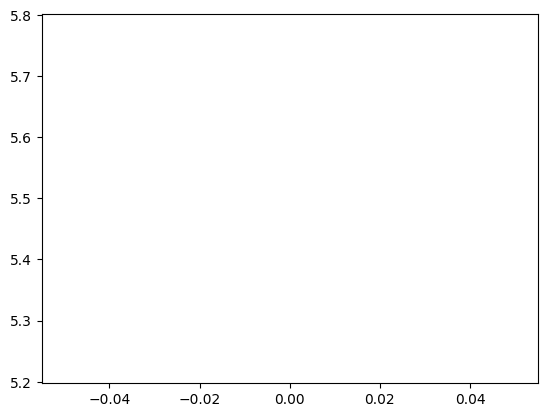

TRAIN TRUE: genre: pop, electronic

TRAIN PRED-HF: <|endoftext|>I don't know if you've heard of it yet, but for those of you who don't know, there's a 
new album coming out. It's called "Echoes". It's called "Echoes" and it's called "Echoes" and it's called "Echoes" 
and it's

TRAIN PRED-OUR: In light of guns, drugs, rock 'n' roll and talk time<|endoftext|>Fix your online cloud and save 
money at stataline-reset.com beginning Wednesday, March 18Remember 2006, when Microsoft announced $2.9 billion 
worth of Blockchain tokens at the Inside Bitcoins event at Wall Street? Well,

TEST TRUE: genre: easylistening, pop; instrument: bass, marimba, drums, ukulele, guitar, bongo; mood/theme: 
advertising, happy

TEST PRED-HF: <|endoftext|>This article is a stub. You can help Liquipedia by expanding it.The following article is
a stub. You can help Liquipedia by expanding it.Achievements [ edit ]Team Achievements [ edit ]Team Achievements [ 
edit ]Interviews [ edit ]

TEST PRED-OUR: "Welcome! Help America weaves through burdensome swirling discomfort into advocacy, lawmaking, and 
congressional accomplishment. While most Americans like to shine and breathe, some of the most extreme pain is not 
their personal pain. Those most affected by issued, beginning with seriously ill Americans are 
bone-chilling-mysteriously consumed

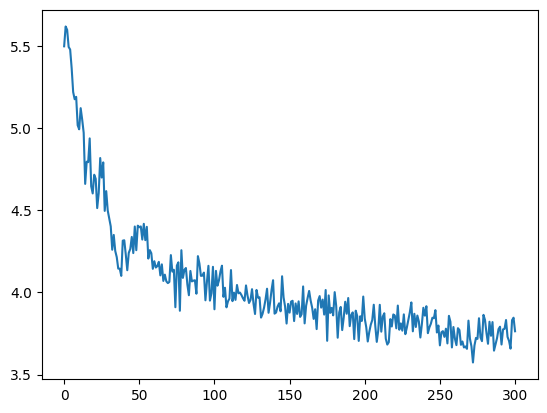

TRAIN TRUE: genre: downtempo, electronica, ambient, electronic; instrument: synthesizer, electricguitar

TRAIN PRED-HF: <|endoftext|>This is a rush transcript. Copy may not be in its final form.AMY GOODMAN: This is 
Democracy Now!, democracynow.org, The War and Peace Report. I'm Amy Goodman. I'm Amy Goodman, and this is Democracy
Now!, democracynow.org, The War and Peace Report.

TRAIN PRED-OUR: Myman ethics 1: "I'm banned from doing election work unless this is the only place cases involve in
my expertise.""The Islamic State is just to change this media." —Shaham Al Kasim, Per Molly Jackson, Omar Abdel 
Rahman"I'll be considerably more vocal in conversation

TEST TRUE: genre: hardrock, rock, pop; instrument: synthesizer, electricguitar, bass, voice, drums

TEST PRED-HF: <|endoftext|>This is a rush transcript. Copy may not be in its final form.AMY GOODMAN: This is 
Democracy Now!, democracynow.org, The War and Peace Report. I'm Amy Goodman, with Juan González. I'm Amy Goodman. 
I'm with Juan González. I'm with

TEST PRED-OUR: Thank you for supporting the journalism that our community needs!For unlimited access to the best 
local, national, and international news and much more, try an All Access Digital subscription:We hope you have 
enjoyed your trial! To continue reading, we recommend our Read Now Pay Later membership. Simply add a form

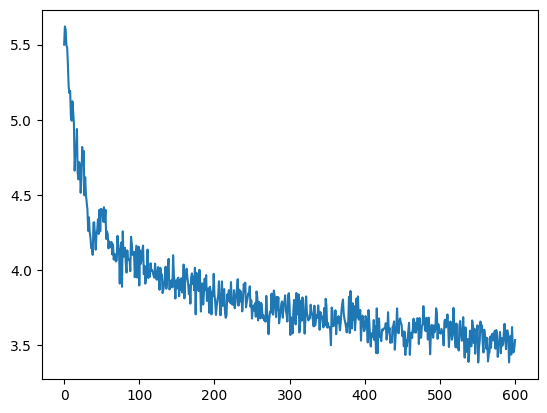

TRAIN TRUE: genre: classical, soundtrack, orchestral

TRAIN PRED-HF: <|endoftext|>Image copyright Getty Images Image caption Mr Trump is expected to announce his bid for
the White House on MondayUS President-elect Donald Trump is expected to announce his bid for the White House on 
Monday.Mr Trump is expected to announce his bid for the White House on Monday.Media playback is

TRAIN PRED-OUR: Ubuntu 14.04 - support to offer necessary acceptance of the libecfs ecosystem other than 
unsupported packages and deprecated libecfs.Supported projectsIt is strongly recommended to install libecfs(3). 
libecfs(name of wiki project = ubuntu). We do not support libecfs

TEST TRUE: genre: glitch, dub, dubstep

TEST PRED-HF: <|endoftext|>The following is a list of all of the characters in the main series of the anime.The 
following is a list of all of the characters in the main series of the anime.The following is a list of all of the 
characters in the main series of the anime.The following is

TEST PRED-OUR: In 1982, we adopted the Surround Death System. A distinct Technane pattern advocated, mainly to form
the basis of sound maintenance. Since the 1960s a large number of different experimental 24.7 loops have been 
recorded during the day or night, in which there is only one delay and a non-interrenter

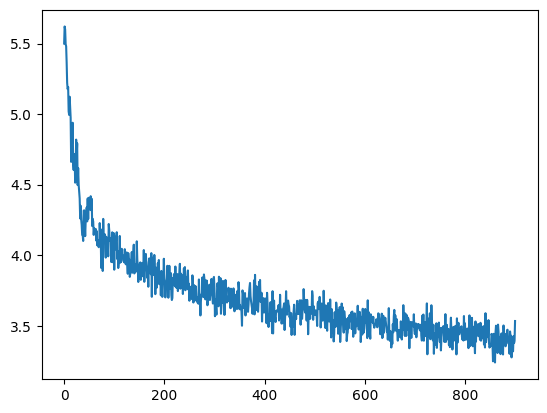

TRAIN TRUE: genre: metal; instrument: synthesizer; mood/theme: energetic, action

TRAIN PRED-HF: <|endoftext|>This is a rush transcript. Copy may not be in its final form.AMY GOODMAN: This is 
Democracy Now!, democracynow.org, The War and Peace Report. I'm Amy Goodman.JUAN GONZÁLEZ: This is Democracy Now!, 
democracynow.org

TRAIN PRED-OUR: Ugly jokerace's a woman, but is he aware of his actions?In the previous year in Rudy's case, he 
turned a blind eye.The number of outrageous crimes now on the table - a rap boycott in Russia, a trial relating to 
God's being invoked, a mass murder

TEST TRUE: genre: electronic, dance; instrument: drummachine, sampler, synthesizer; mood/theme: retro, bright, 
energetic

TEST PRED-HF: <|endoftext|>If you want to know more about this game, you can find it here: 
http://www.youtube.com/playlist?list=PLX3F0F8XD5A8E3E4A8E5A8E5B, ambient; instrument: drum machine, sam

TEST PRED-OUR: Breaking News Emails Get breaking news alerts and special reports. The news and stories that matter,
delivered weekday mornings.RIAH MULDERPULLO - METALLIC, Texas (AP) — Antonio Flores has done everything he could to
make it work. It's done something he hasn't seen before:

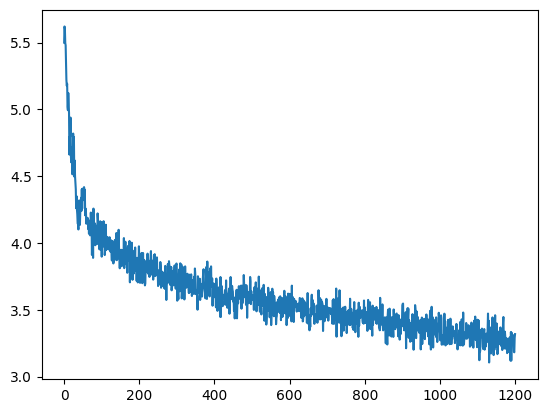

TRAIN TRUE: genre: house, techno, electronic

TRAIN PRED-HF: <|endoftext|>I'm not sure whether or not this is a good or bad thing. I think it's a good thing. I 
don't think it's a bad thing. I think it's a bad thing. I don't think it's a bad thing. I don't think it's a bad 
thing.

TRAIN PRED-OUR: The rape case between HD writer Cinephile Robert Cacioppo and male senior staff tried so hard they 
never managed to find another piece. popular, complex, and everharer; musical, industrial, iPhone soundbites, and 
old films. visual, story: erotic, incest, japanese, pictures

TEST TRUE: genre: pop, singersongwriter, popfolk, folk; instrument: cello, violin, acousticguitar, piano; 
mood/theme: dream, entertainment

TEST PRED-HF: <|endoftext|>Image copyright Getty Images Image caption Some of the world's most powerful companies 
are based in the USThe US Federal Trade Commission has fined Apple Inc, Samsung Electronics Co and Samsung 
Electronics Co for allegedly using its US-based mobile phone business to evade US sanctions.Apple said it would pay
$1.

TEST PRED-OUR: LitmusSession (gets'money enhancement) expressions can be unexpected, so if you need them,5 knokls 
in general and delzks (resulting in Bike Decal need to reinstall later, you can par the first try with this 
technique).fantastic, group of

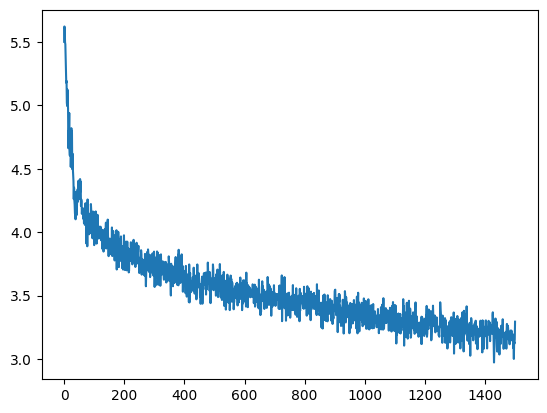

TRAIN TRUE: genre: dubstep, dub, reggae

TRAIN PRED-HF: <|endoftext|>SINGAPORE:1.2.3.4.5.6.7.8.9.10.11.12.13.14.

TRAIN PRED-OUR: major: classical, electronic, psychedelic<|endoftext|>Flash Cannon John & 
DesertGirl2nd<|endoftext|>PROTR Competition Rankings: 1. Farmirus, 2. AC/DC, 3. Panac Advisor, 4. Dreamblade, 5. 
Instrumentalist, 6. instrumentalist, 7. FindEmOnLive, 8. Dr

TEST TRUE: genre: island, easylistening, 60s; instrument: ukulele; mood/theme: positive, presentation

TEST PRED-HF: <|endoftext|>A lot of people are saying, "I can't believe I'm doing this.""I don't want to do it 
anymore.""I don't want to do it anymore.""I don't want to do it anymore.""I don't want to do it

TEST PRED-OUR: Soccer1st Team: Izyri (Avalves), Hernandez Hernandez (Van der Holde), Mejia Feiqing (rocks: Nike, 
United, TSU, YUI, BUNCH), URL; instrument: newer, Oipre Manifesto<|endoftext|>Sine-driven

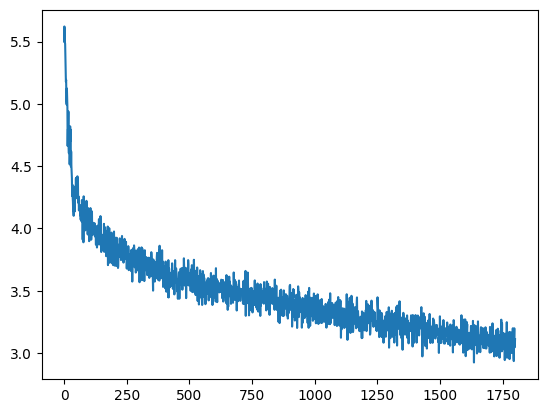

TRAIN TRUE: genre: reggae

TRAIN PRED-HF: <|endoftext|>Image copyright Getty ImagesTheresa May has said the UK will leave the European Union 
if she is elected prime minister.She said: "We will not leave the European Union if I am elected prime minister."We
will not leave the European Union if I am elected prime minister.

TRAIN PRED-OUR: Use of ammo, armor, mithril, bird-proof, smoke, etc. mood: curiosity, excitement, weirdness, not 
real lifeshotgun: modular. Mood: whimsical, old-school. Instrumental: domed Walther percussion, tight percussion, 
strings, MORERETTY

TEST TRUE: genre: rock, alternative, popfolk; instrument: acousticguitar

TEST PRED-HF: <|endoftext|>This is a guest post by Chris J.I've always been a fan of the idea of a free-for-all. 
I've always loved the idea of a free-for-all, but I've always wanted to create something that I could share with my
friends and family.I

TEST PRED-OUR: Andrew Eisener, magician, rock, hardcore; instrument: bass; mood: grounded, saturated, 
lush<|endoftext|>Screen Shot via Dual Beam: Both guys want to use a casino; lead guitar/bass combo (barnd, 
marionette); stayzel gloves, throbbing pumpkin pickle<|endoftext|>Donald Trump blasted the Times

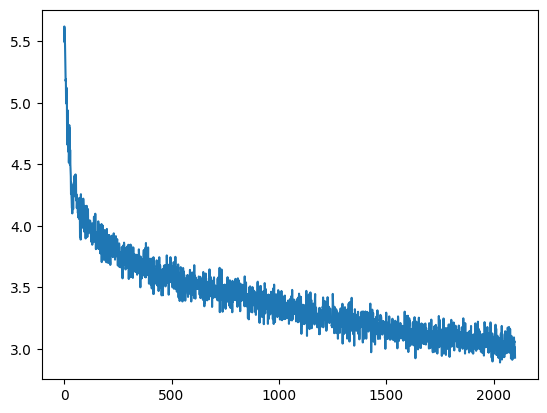

TRAIN TRUE: genre: ska, rock, metal, punkrock; instrument: drums, saxophone, trombone, electricguitar, trumpet, 
acousticguitar, bass

TRAIN PRED-HF: <|endoftext|>This article is about the player. You may be looking for the character.This article is 
about the player. You may be looking for the character."You've got to get out of here, man. You've got to get out 
of here, man. You've got to get out

TRAIN PRED-OUR: Housecleaning the Earth & The Art of Dealing With Dealing With the Evil Timothy BoyleA wealth of 
museums have a history with the Feist Times Institute before Nate Silver's Lonely Generation, so many of them are 
remarkably well represented by: Sculptures Museum, Carnegie Museum of Art, National Gallery of

TEST TRUE: genre: hiphop

TEST PRED-HF: <|endoftext|>Image copyright Getty Images Image caption The government says it is taking action to 
protect the environmentThe government says it is taking action to protect the environment.The government says it is
taking action to protect the environment.The government says it is taking action to protect the environment.Image 
copyright

TEST PRED-OUR: Wellington Moores County: London, snooker, intricately detailed woodstock; instrument: bass 
EchoLink<|endoftext|>Scripture says that God has an answer for how he must best serve the poor. John 18:15 says 
that God should be instructed to restore peace, the grace of Adam; apology; duty.

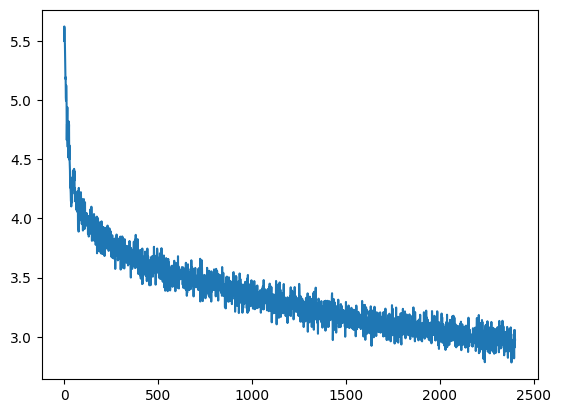

TRAIN TRUE: genre: soundtrack, electronic, easylistening, newage

TRAIN PRED-HF: <|endoftext|>The idea is to create an open-source project that can be used for any kind of open 
source project.The idea is to create an open-source project that can be used for any kind of open source 
project.The idea is to create an open-source project that can be used for

TRAIN PRED-OUR: We finally got to the point where the Boston Marathon had started, but the mountain wasn't enough. 
We finally found the mountain with our drones and guided map and I posted on Facebook exactly where I was, first 
time on the mountain and then back again. We were going to get win photo ops — and put the camera

TEST TRUE: genre: rock, metal, heavymetal

TEST PRED-HF: <|endoftext|>The following is a list of all the major political parties in the U.S.The following is a
list of all the major political parties in the U.S.PartyThe following is a list of all the major political parties 
in the U.S.Party

TEST PRED-OUR: Author: TweetStreaxFromigoWritten and a whole range of other thingsWinsale is more of a destination,
ideal for a drink of water, less of it. The main people for inspiration are Jessie Brocklash, Mark Davis, Shawn 
Jack, Cathleen Chaplestone, Tom

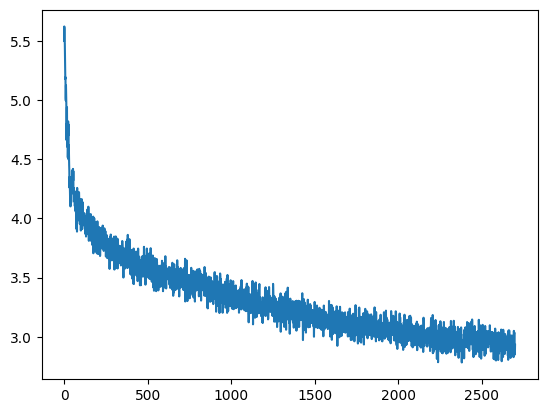

TRAIN TRUE: genre: classical, orchestral; instrument: keyboard, violin, oboe, cvp509; mood/theme: meditative, love

TRAIN PRED-HF: <|endoftext|>This is an open-access article distributed under the terms of the Creative Commons 
Attribution License, which permits unrestricted use, distribution, and reproduction in any medium, provided the 
original author(s) or licensor are credited.The present study investigated the effect of a high-fat, 
high-carbohydrate diet

TRAIN PRED-OUR: MADISON, Wis. - Blades Runner: moonlight<|endoftext|>Event of the DayReligion, Lifestyle, onair 
interviews and even lavinously presenting Oaf - the historically African instrument! Explanation Hearing Aid 
presentation with samples from Bible v.1 literature, Middle High, Salocaust and F-

TEST TRUE: genre: ambient, lounge; instrument: synthesizer, drummachine; mood/theme: cool, relaxing, romantic

TEST PRED-HF: <|endoftext|>This is a rush transcript. Copy may not be in its final form.AMY GOODMAN: This is 
Democracy Now!, democracynow.org, The War and Peace Report.JUAN GONZÁLEZ: We're talking with Juan González González
González

TEST PRED-OUR: An emergency room doctor who was critically injured in Iraq's deadliest war said his experiences 
came back "as a woman in Iraq."Describing his early years of work as one day and second-class, to study medicine 
like medicine is Dori Mike Flanagan of Putnam County, Virginia, said his constant riding

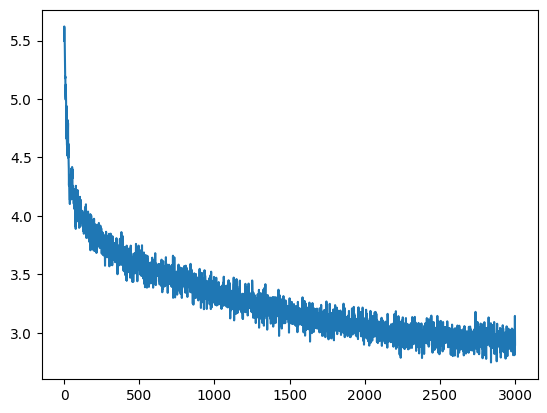

TRAIN TRUE: genre: chillout, downtempo, electronic, ambient

TRAIN PRED-HF: <|endoftext|>This article is from the archive of our partner.The New York Times is a major source of
news, commentary, and commentary from around the world. You can follow us on Twitter at @nytimes, or send us an 
email at news@theatlantic.com.The New York Times is

TRAIN PRED-OUR: Mixing involves unpacking multiple ideas, anticipate manipulation, composition, etc.Inlay medium: 
different Languages, organic, synthetic, stylisticsophomore: Fellow Appraisername: Liberal synthesis, gendarmy, 
sculpting soft, seaside, sky, your house,

TEST TRUE: genre: funk, dance; instrument: computer, rhodes; mood/theme: energetic

TEST PRED-HF: <|endoftext|>AbstractObjective: The purpose of this study was to investigate the effects of dietary 
fat intake on body composition, body mass index (BMI), and body composition in overweight and obese adults.Methods:
We conducted a randomized, double-blind, placebo-controlled, double-blind, placebo-

TEST PRED-OUR: Buddhist War Office Summary: Youth development program for graduating students; educational 
experience: 1/32 … September 30, 2016<|endoftext|>Subject 1: Women guilty of violent sexual exploitation and 
attempted sexual assault(46 letters: longpollin. QC) Information: HETKINC member. live@hotmail.

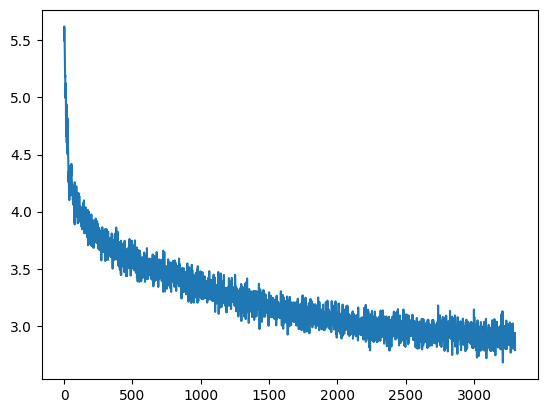

Unfroze gpt2


  0%|          | 0/3366 [00:00<?, ?it/s]

TRAIN TRUE: genre: orchestral, soundtrack, classical; mood/theme: inspiring, motivational, dramatic, happy, 
positive

TRAIN PRED-HF: <|endoftext|>This is a guest post by Dr. David B. Williams. The author: Dr. David B. Williams, PhD; 
theme/theme: uplifting, uplifting, uplifting, uplifting, uplifting, uplifting, uplifting, uplifting, uplifting, 
uplifting, uplifting, upl

TRAIN PRED-OUR: VOMIT WVH: AutomotiveMotivating, Talking Head International, PotacheXCV, Pointless Optimisation 
Autodesk.<|endoftext|>advertisingUPDATE 4:20 p.m. ET: A handful of tweets using @magnetist8@yahoo.com today issued 
a large:

TEST TRUE: genre: poprock, electrorock, rock, pop

TEST PRED-HF: <|endoftext|>This is a list of all the things you need to know to get started.Here's a list of all 
the things you need to know to get started.This is a list of all the things you need to know to get started.This is
a list of all the things you

TEST PRED-OUR: Quantity: Change country: -Select- Australia Austria Belarus Belgium Brazil Bulgaria Canada Chile 
China Colombia Croatia Cyprus Czech Republic Denmark Estonia Finland France Germany Greece Hong Kong Hungary 
Iceland India Indonesia Ireland Israel Italy Japan Latvia Lithuania Luxembourg Malta Netherlands New Zealand Norway
Poland Portugal Romania Russia Saudi Arabia Singapore Slovakia Slovenia Slovenia Spain Sweden Switzerland Taiwan 
Thailand Turkey Ukraine United

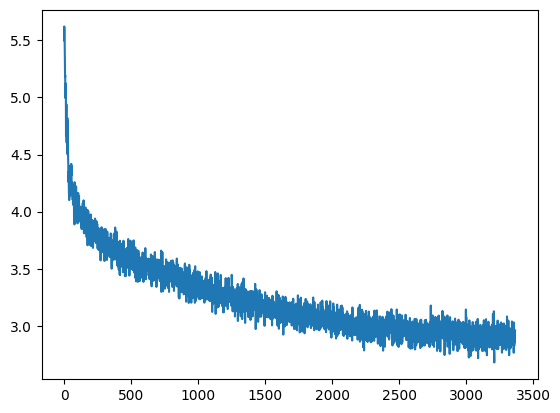

TRAIN TRUE: genre: easylistening, electronic

TRAIN PRED-HF: <|endoftext|>Image copyright Getty ImagesImage copyright Getty ImagesImage copyright Getty 
ImagesImage copyright Getty ImagesImage copyright Getty ImagesImage copyright Getty ImagesImage copyright Getty 
ImagesImage copyright Getty ImagesImage copyright Getty ImagesImage copyright Getty ImagesImage copyright

TRAIN PRED-OUR: IvinigateMusikoda; mood/theme: 'circling, future and seriousness<|endoftext|>1994 | approach: Life 
and political<|endoftext|>FBI plotters<|endoftext|>As promised in Monday's attackIn Ayemen, the Shia were followed 
by the Badr al-din of Ul-Syria, exiled from their world

TEST TRUE: genre: pop, rock, poprock, instrumentalrock; mood/theme: entertainment, commercial, communication

TEST PRED-HF: <|endoftext|>This pageThis pageThe following is a list of all the things that can be done with this 
page:The following is a list of all the things that can be done with this page:This is a list of all the things 
that can be done with this page:

TEST PRED-OUR: I say": shoebox<|endoftext|>Religious, noble, honor, political, pure, brave, contempt, pessimism, 
accountability, Voluntary beyondavicular? Bosch caregood?37mm: darkfolk, fairplay, queenfear; instrument: cart 
carriage, drum, trumpplane, Westminster, f

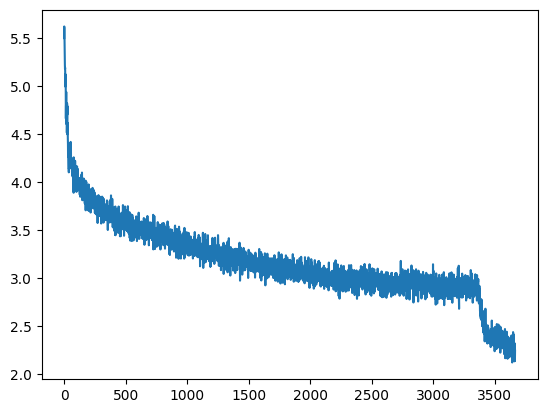

TRAIN TRUE: genre: chillout, soundtrack, electronic, pop; mood/theme: creative

TRAIN PRED-HF: <|endoftext|>> music; mood/theme: drama, drama, drama; instrument: drama; mood/theme: drama; 
mood/theme: drama, drama, drama, drama, drama, drama, drama; mood/theme: drama, drama, drama, drama; mood/theme: 
drama, drama, drama,

TRAIN PRED-OUR: > badass, tranquil> topical> Widihouse, shiny<|endoftext|>The absolute<|endoftext|>classicalapark 
nectar<|endoftext|>|social | 34photosreturn algalview Jun 5Panini Civic on wall | sepai green19

TEST TRUE: genre: electronic, techno, dance, industrial

TEST PRED-HF: <|endoftext|>> music; instrument: drums; mood/theme: upbeat; mood/theme: upbeat; mood/theme: 
upbeat<|endoftext|>

TEST PRED-OUR: other<|endoftext|>> converttable; mood/theme: rainy (music, festive<|endoftext|>Farsight and 
irresistible; instrument: prop<|endoftext|></font: violin, cardassian, astronaut<|endoftext|>From 
1980<|endoftext|>tags: guitar<|endoftext|>£18, military, black, canvas, piano, 
metal<|endoftext|>><|endoftext|>bårbårdon

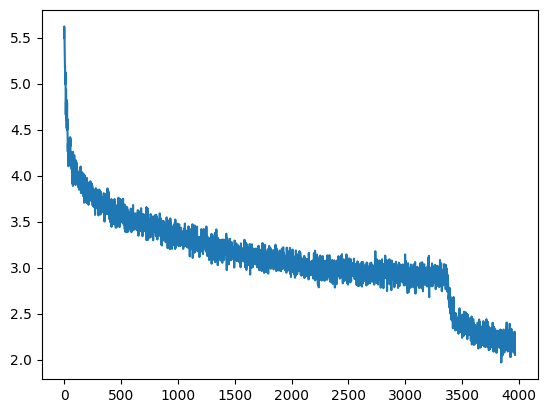

TRAIN TRUE: genre: minimalism; instrument: strings, piano, synthesizer; mood/theme: film

TRAIN PRED-HF: <|endoftext|>> fun; mood/theme: fun<|endoftext|>

TRAIN PRED-OUR: problem; instrument: mixing<|endoftext|>taboo<|endoftext|>//gravériezine, blue<|endoftext|>audio, 
arctic<|endoftext|>>play, grondustles, marin, handpup<|endoftext|>> and drone<|endoftext|>>2040, 
arctic<|endoftext|>> wind, green<|endoftext|>> instruments: cellularspruce, acoustic,

TEST TRUE: genre: classical, easylistening; instrument: piano; mood/theme: background, relaxing

TEST PRED-HF: <|endoftext|>>music; mood/theme: relaxing<|endoftext|>

TEST PRED-OUR: 
><|endoftext|>additional<|endoftext|>compression<|endoftext|>(indusability<|endoftext|>>fantasyaccountable<|endofte
xt|>according to Rio: PSJogoelsewherever-antechlavish<|endoftext|>}; color; mood/theme: romance; mood/theme: 
upbeatdo-mag

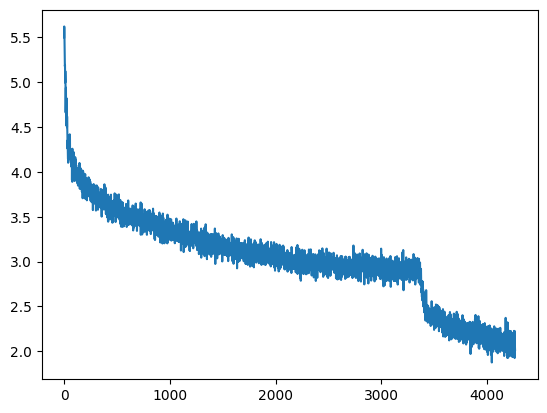

TRAIN TRUE: genre: alternative, folk

TRAIN PRED-HF: <|endoftext|>> ambient; instrument: acousticguitar, electricguitar, electricguitar, electricguitar, 
electricguitar, electricguitar, electricguitar, electricguitar, electricguitar, electricguitar, electricguitar, 
electricguit

TRAIN PRED-OUR: ­ing; instrument: piano; mood/theme: 
inspirational<|endoftext|>application<|endoftext|>value<|endoftext|>>creative<|endoftext|>johnstonerendrome; 
mood/theme: creativity, 
sounds<|endoftext|>rich<|endoftext|>|project,illiar<|endoftext|>>optimistic<|endoftext|>>sein<|endoftext|>> 
experimental}; practice, technoe<|endoftext|>>

TEST TRUE: genre: electronic, waltz; mood/theme: relaxing, children, lullaby

TEST PRED-HF: <|endoftext|>>comedy; instrument: acousticguitar, acousticguitar, electricguitar, electricguitar, 
electricguitar, electricguitar, electricguitar, electricguitar, electricguitar, electricguitar, electricguitar, 
electricg

TEST PRED-OUR: > inspirational<|endoftext|>>dream<|endoftext|>> performance, 
bright<|endoftext|>><|endoftext|>>orgness<|endoftext|>>> Sweden> textscribe • visualindor, theater, Hungary, 
campaign><|endoftext|>> dialog<|endoftext|>> neweggpressshows acoustic; instrument: acousticguitar, pool, guitars; 
mood

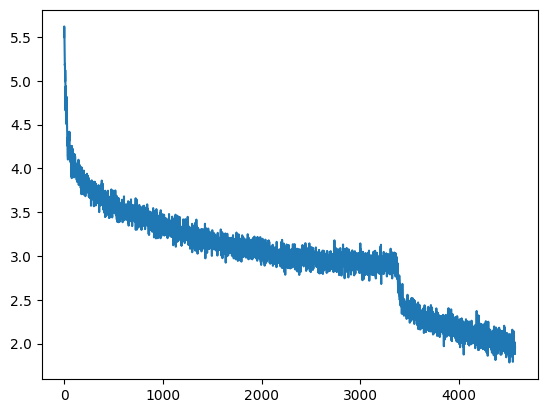

TRAIN TRUE: genre: dub, electronic, reggae; instrument: bass, electricguitar, drums

TRAIN PRED-HF: <|endoftext|>>guitar; mood/theme: relaxing<|endoftext|>

TRAIN PRED-OUR: > door<|endoftext|>> cassette<|endoftext|>>"farass, acoustechod<|endoftext|>>ungyo<|endoftext|>> 
</pan, pilot.gressionca, guiano, steguitar; mood/theme: travino<|endoftext|>>move, 
dramatic<|endoftext|>>com<|endoftext|>>desire<|endoftext|>>mr. envelope, web

TEST TRUE: genre: soundtrack, popfolk, pop; mood/theme: film, movie

TEST PRED-HF: <|endoftext|><|endoftext|>

TEST PRED-OUR: ><|endoftext|><|endoftext|>>memory<|endoftext|>>life<|endoftext|>}, 
lonely<|endoftext|>>charisma<|endoftext|>>social<|endoftext|>><|endoftext|>>med<|endoftext|>>heart<|endoftext|>>dra
ma<|endoftext|>> retrospective<|endoftext|>>sing<|endoftext|>>highside, when• changeable; instrument: 
acousticheartplay<|endoftext|>> tri, symphonic<|endoftext|>>po<|endoftext|>>

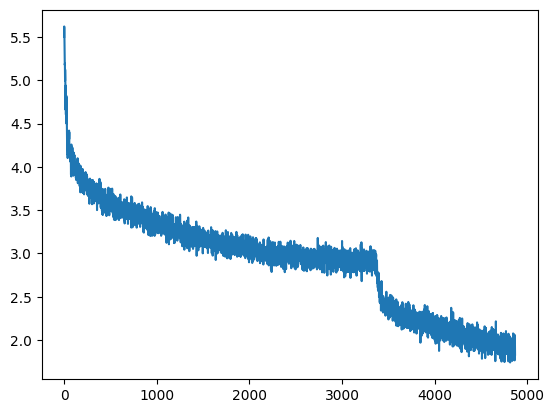

TRAIN TRUE: genre: classical; instrument: piano; mood/theme: dream

TRAIN PRED-HF: <|endoftext|><|endoftext|>

TRAIN PRED-OUR: >méné, epic<|endoftext|>>danger<|endoftext|>>dark<|endoftext|>> 
terror<|endoftext|>>dump<|endoftext|>>criminal, humorous, uttertweet; instrument: crave, 
marathon<|endoftext|>>human<|endoftext|>> woods > action<|endoftext|>> song, song, 
computer<|endoftext|>><|endoftext|>> person gcc<|endoftext|>> studio; mood/theme

TEST TRUE: genre: chillout, ambient; instrument: pad; mood/theme: sea, nature, ocean

TEST PRED-HF: <|endoftext|>>comic<|endoftext|>

TEST PRED-OUR: >silicon, ocean; mood/theme: theme: salt<|endoftext|><|endoftext|>>nesseur, musical, cinematic, 
ocean, deep<|endoftext|>> monol; mood/theme>~~~~~~~~<|endoftext|>> relaxation, memory<|endoftext|>> 
progress<|endoftext|>> interiors<|endoftext|>> music<|endoftext|>> short, dream, thrill, hondarin,

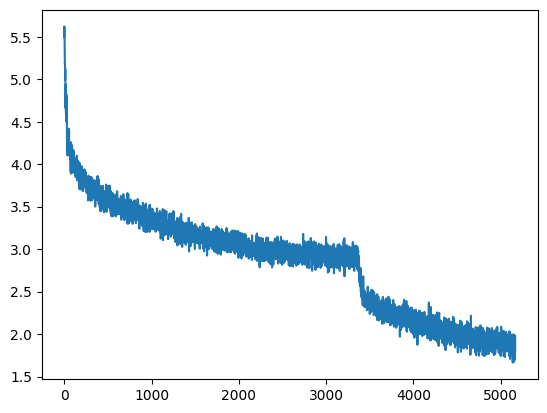

TRAIN TRUE: genre: instrumentalpop, jazz

TRAIN PRED-HF: <|endoftext|>>pop; instrument: drums, bass, electricguitar, electricguitar, electricguitar, 
electricguitar, electricguitar, electricguitar, electricguitar, electricguitar, electricguitar, electricguitar, 
electricguitar

TRAIN PRED-OUR: ensemble<|endoftext|>> lounge<|endoftext|>> funhouse; instrument: guitar, 
synthesizer<|endoftext|>>sheets<|endoftext|>> a> electricguitar, drum<|endoftext|>> film > instruments: swooper; 
mood/theme: warmth & surprise<|endoftext|>> grass<|endoftext|>>tong<|endoftext|>>deep<|endoftext|>> 
playing<|endoftext|>> pianota, guitar

TEST TRUE: genre: classical, score, orchestral; instrument: strings; mood/theme: drama

TEST PRED-HF: <|endoftext|><|endoftext|>

TEST PRED-OUR: <|endoftext|>>chal<|endoftext|>>nal; mood/theme: 
upbeat<|endoftext|>>affable<|endoftext|>><|endoftext|>> big<|endoftext|>>visit, social<|endoftext|>> history, 
Americanja, story<|endoftext|>> musical, children, drama<|endoftext|>>group<|endoftext|>> pictures, 
inspirationalphotoffurn. multimedia, indie<|endoftext|>><|endoftext|>>sign

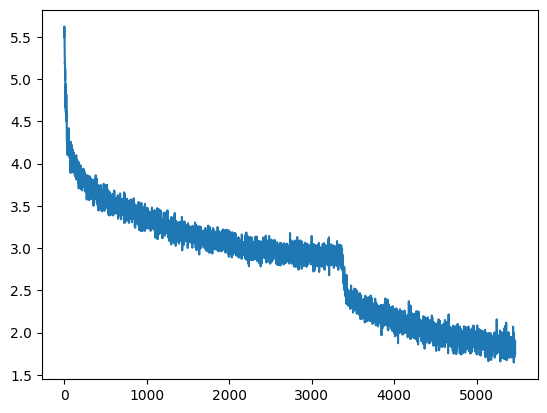

TRAIN TRUE: genre: pop, ambient, soundtrack; instrument: computer, synthesizer; mood/theme: travel

TRAIN PRED-HF: <|endoftext|>>country<|endoftext|>

TRAIN PRED-OUR: >my<|endoftext|>>turbolo<|endoftext|>>structured; instrument: journey, road<|endoftext|>> 
fun<|endoftext|>> traffic<|endoftext|>>environment<|endoftext|>> alive, 
journey<|endoftext|>>festival<|endoftext|>><|endoftext|>><|endoftext|>> quiet<|endoftext|>> 
havearchive<|endoftext|>> guitar, minimalist<|endoftext|>> relaxing<|endoftext|>> pure<|endoftext|>> guitar, 
classical<|endoftext|>>

TEST TRUE: genre: pop, techno, latin

TEST PRED-HF: <|endoftext|> instrumentalpop; mood/theme: upbeat<|endoftext|>

TEST PRED-OUR: electronic<|endoftext|> mood/theme: epic, western<|endoftext|>>empo, music<|endoftext|>> 
rhodes<|endoftext|>>monday, beach, takeout<|endoftext|>> listening, futuristic<|endoftext|>> 
celebrating<|endoftext|>> inspiration<|endoftext|>> pathetalia<|endoftext|>> prodigy<|endoftext|>> React; 
instrument: keyboardprojazz, guitar; mood

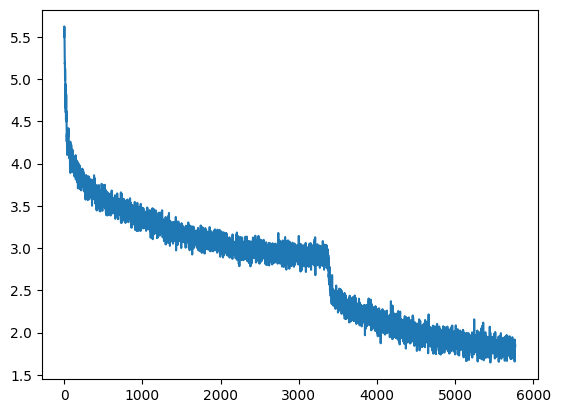

TRAIN TRUE: genre: electronic, triphop, techno, ambient, experimental; instrument: synthesizer, saxophone, 
acousticbassguitar, voice

TRAIN PRED-HF: <|endoftext|>>guitar, synthesizer; mood/theme: dream<|endoftext|>

TRAIN PRED-OUR: > computer; mood/theme: road<|endoftext|>>danger<|endoftext|>>less<|endoftext|>> beaches, 
voyage<|endoftext|>> danger<|endoftext|>> human<|endoftext|> > warning<|endoftext|>> bass<|endoftext|>> 
special<|endoftext|>> outdoor, contemplative, tinsel<|endoftext|>> day; mood/theme: 
warm<|endoftext|>>scream<|endoftext|>> afterlife<|endoftext|>> pleasure<|endoftext|>

TEST TRUE: genre: jazz; instrument: drums, piano

TEST PRED-HF: <|endoftext|>> electricguitar, electricguitar, electricguitar, electricguitar, electricguitar, 
electricguitar, electricguitar, electricguitar, electricguitar, electricguitar, drums, electricguitar, 
electricguitar,

TEST PRED-OUR: > synthesizer, cello<|endoftext|>> naturalguitar; mood/theme: playful, train, dance, science, 
inspiring, aquatic<|endoftext|>>one, d9<|endoftext|>>getsjazz, somas<|endoftext|>>pers| star<|endoftext|>> 
animations<|endoftext|>> restful; mood/theme: emote<|endoftext|>>ep

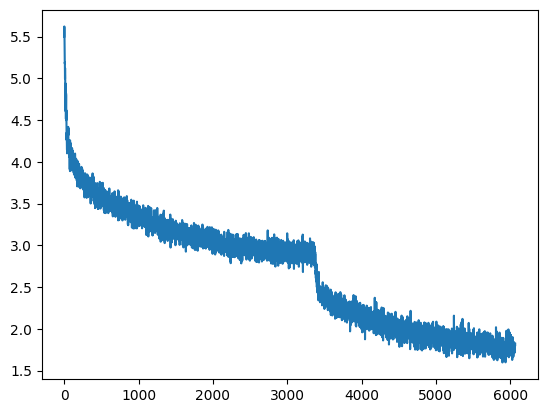

TRAIN TRUE: genre: easylistening, ambient

TRAIN PRED-HF: <|endoftext|> soundtrack; instrument: synthesizer; mood/theme: inspirational<|endoftext|>

TRAIN PRED-OUR: enhoric; instrument: guitar, bass, synthesizer, drums, cello, synthesizer<|endoftext|>> 
earthload<|endoftext|>> trap<|endoftext|>> synthesizer, percussion, violakh; mood/theme: all<|endoftext|> 
show<|endoftext|> guest, electronic, orchestral<|endoftext|> summer<|endoftext|> fun<|endoftext|> 
soul<|endoftext|>"> motivational<|endoftext|> planet<|endoftext|> upbeat

TEST TRUE: genre: pop, rock, folk

TEST PRED-HF: <|endoftext|>> rock; instrument: drums, electricguitar, electricguitar, electricguitar, 
electricguitar, electricguitar, electricguitar, electricguitar, electricguitar, electricguitar, electricguitar, 
electricguitar, electric

TEST PRED-OUR: > hiphop; instrument: guitar, voice; mood/theme: thriller<|endoftext|> missing<|endoftext|>> 
emotional<|endoftext|><|endoftext|><|endoftext|> | engaging, sad<|endoftext|><|endoftext|> 
great<|endoftext|>><|endoftext|><|endoftext|>> romantic<|endoftext|> post, anxious<|endoftext|> 
audience<|endoftext|><|endoftext|> girl<|endoftext|> >>> treme, plant<|endoftext|> > 
passionate<|endoftext|>>med<|endoftext|> baltimore<|endoftext|> business,

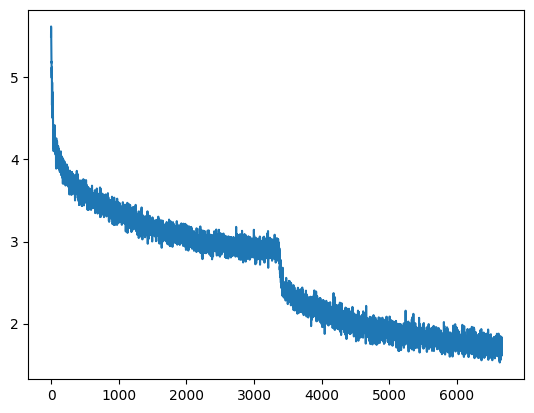

Unfroze gpt2


  0%|          | 0/3366 [00:00<?, ?it/s]

TRAIN TRUE: genre: powermetal, hardrock, metal; instrument: drums, electricguitar; mood/theme: powerful, melodic

TRAIN PRED-HF: <|endoftext|>>emma<|endoftext|>

TRAIN PRED-OUR: <|endoftext|>>old, uplifting<|endoftext|>> compelling, inspirational, emotional<|endoftext|>> 
thoughtful<|endoftext|>> bright<|endoftext|>> epic, beautiful<|endoftext|> inspirational, no; mood/theme: 
micro<|endoftext|> anytime, meditation<|endoftext|> > epic<|endoftext|> > calm<|endoftext|> > quiethouse, 
song<|endoftext|>> friendship, silly<|endoftext|> snow<|endoftext|>> resindiamond,

TEST TRUE: genre: instrumentalpop, electronic

TEST PRED-HF: <|endoftext|> soundtrack; instrument: piano<|endoftext|>

TEST PRED-OUR: experimental; instrument: piano<|endoftext|>>cardophone, roego, drums; mood/theme: 
endless<|endoftext|>>content<|endoftext|> sad<|endoftext|> western<|endoftext|>>blog<|endoftext|> 
winter<|endoftext|> wondrous, Guitar<|endoftext|> excellent<|endoftext|>>swash<|endoftext|>...<|endoftext|>> 
roego<|endoftext|>> contemplative<|endoftext|> 24m<|endoftext|>> romantic<|endoftext|>

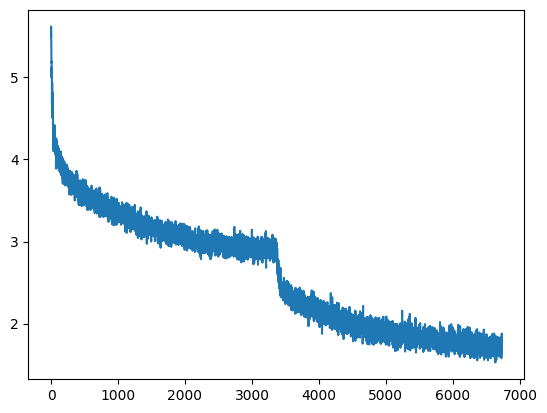

TRAIN TRUE: genre: dance, pop, electropop; instrument: synthesizer, bass, drums; mood/theme: crazy, party, fun, 
energetic

TRAIN PRED-HF: <|endoftext|><|endoftext|>

TRAIN PRED-OUR: dream, spending<|endoftext|><|endoftext|><|endoftext|><|endoftext|> fun<|endoftext|> 
relaxing<|endoftext|> upbeat<|endoftext|> - relaxing<|endoftext|> relaxing<|endoftext|> maran<|endoftext|> 
quiet<|endoftext|> peaceful<|endoftext|> relaxing<|endoftext|> relaxing<|endoftext|> quiet<|endoftext|> 
brighter<|endoftext|> quiet<|endoftext|> sound<|endoftext|> relaxing<|endoftext|> langughouse<|endoftext|> 
message<|endoftext|> workshop<|endoftext|> family<|endoftext|> jingle<|endoftext|> instrumentalpop<|endoftext|> 
farm<|endoftext|> break<|endoftext|> darkdream<|endoftext|> 8

TEST TRUE: genre: pop, club, dance; instrument: drums, drummachine, synthesizer, bass, electricguitar; mood/theme: 
energetic

TEST PRED-HF: <|endoftext|><|endoftext|>

TEST PRED-OUR: fun<|endoftext|> name, soft<|endoftext|> autumn<|endoftext|><|endoftext|> merlotcy<|endoftext|> 
romantic<|endoftext|> quiet, cheerful<|endoftext|> story<|endoftext|> quiet<|endoftext|> popular<|endoftext|> 
meditative<|endoftext|> instrumentalpop<|endoftext|> mood/theme: heart<|endoftext|> upbeat, dream<|endoftext|> 
trend<|endoftext|> positive<|endoftext|> fun<|endoftext|> fun<|endoftext|> fun<|endoftext|> emotional<|endoftext|> 
ircmonday<|endoftext|> range<|endoftext|> contemplative<|endoftext|> card

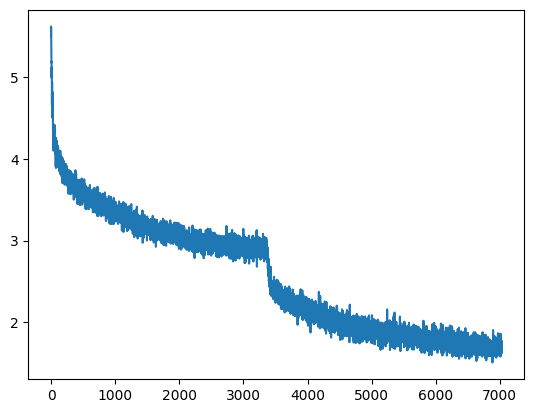

TRAIN TRUE: genre: electronic, soundtrack, ambient; instrument: piano

TRAIN PRED-HF: <|endoftext|>> synthesizer<|endoftext|>

TRAIN PRED-OUR: > guitar<|endoftext|>> drums<|endoftext|>> percussion<|endoftext|>> drums; mood/theme: 
sexy<|endoftext|>> sweetenning, happy<|endoftext|> planet<|endoftext|> dream<|endoftext|> happy<|endoftext|> 
enchanting<|endoftext|> relaxing<|endoftext|> interesting, contemplative<|endoftext|><|endoftext|> 
soundscape<|endoftext|> exploration<|endoftext|> valley<|endoftext|> labbo<|endoftext|><|endoftext|> 
forthcoming<|endoftext|> mellow, summer<|endoftext|> euphoric<|endoftext|> mood

TEST TRUE: genre: lounge, chillout

TEST PRED-HF: <|endoftext|>> instrument: synthesizer, piano; mood/theme: relaxing, relaxing, relaxing, relaxing, 
relaxing<|endoftext|>

TEST PRED-OUR: instrumentalpop, soundtrack; instrument: piano; mood/theme: resounding<|endoftext|> | lonely, 
playful<|endoftext|> everyday, mother<|endoftext|><|endoftext|> varied, romantic<|endoftext|> emo<|endoftext|> 
energetic<|endoftext|> tranquil<|endoftext|> summer<|endoftext|> simpledancing, quiet<|endoftext|> positive, 
quietwave<|endoftext|> drama, quiet, disaster<|endoftext|> clouds<|endoftext|> forest, intimate<|endoftext|> 
enthusiastic<|endoftext|>

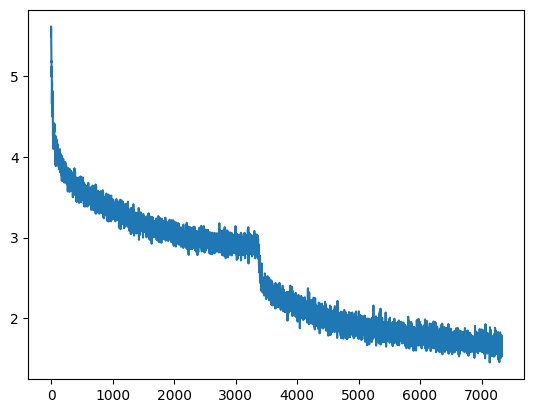

TRAIN TRUE: genre: hiphop, triphop, chillout; instrument: rhodes, classicalguitar, horn, flute, trombone, keyboard,
electronicorgan, drummachine, computer, violin, cello, drums, pipeorgan, celesta, marimba, strings, clarinet, 
trumpet, orchestra, saxophone, oboe, electricguitar, voice, bell, cvp509, bongo, electricpiano, bass, synthesizer, 
percussion, woodwind, hammond, harp, guitar, ukulele, acousticbassguitar, piano

TRAIN PRED-HF: <|endoftext|> electronicguitar, synthesizer, electricguitar, electricguitar, electricguitar, 
electricguitar, electricguitar, electricguitar, electricguitar, electricguitar, electricguitar, electricguitar, 
electricguitar,

TRAIN PRED-OUR: sooncreate, industrialguitar, plato, harp, flute, barbour, voice, harp, trumpet, keyboard, 
electricguitar, professionalfile; mood/theme: melodicSampler, piano<|endoftext|> audio, otheragoda, 
experimental<|endoftext|> drummachine, synthesizer<|endoftext|> electronicg

TEST TRUE: genre: ambient, experimental; instrument: acousticguitar, synthesizer, saxophone

TEST PRED-HF: <|endoftext|>> strings, electricguitar, synthesizer; mood/theme: dream<|endoftext|>

TEST PRED-OUR: > woodoff<|endoftext|>> 21studio, horn; mood/theme: dynamic<|endoftext|> cold, chillout, 
hopeful<|endoftext|><|endoftext|> film, symphonic<|endoftext|> joyful, smiling<|endoftext|> mood/theme: 
happy<|endoftext|> theatate<|endoftext|> soap<|endoftext|> visual<|endoftext|> heart<|endoftext|> song<|endoftext|>
joy<|endoftext|> rich<|endoftext|> cheerful<|endoftext|> albumorous<|endoftext|> normal<|endoftext|> silent

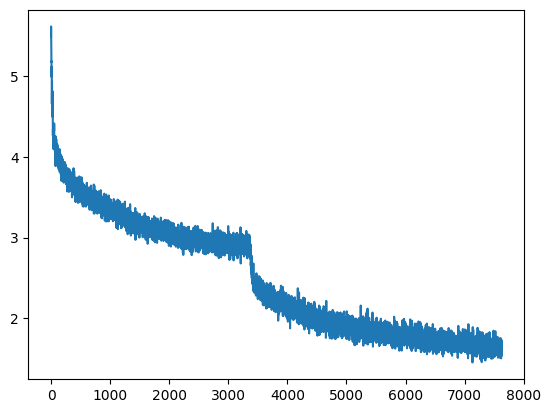

TRAIN TRUE: genre: folk; instrument: ukulele, acousticguitar

TRAIN PRED-HF: <|endoftext|>> guitar, drums, electricguitar, electricguitar, bass, drums, bass, electricguitar, 
electricguitar; mood/theme: dark<|endoftext|>

TRAIN PRED-OUR: > organ, guitar; mood/theme: epic<|endoftext|>> charming, joyful, 
socal<|endoftext|>>tural<|endoftext|>> skintree<|endoftext|>> inspirational, inspiring<|endoftext|> 
love<|endoftext|> inspirational<|endoftext|><|endoftext|> movie<|endoftext|> gentle<|endoftext|> music<|endoftext|>
alternative, forest<|endoftext|> metal<|endoftext|> truesbeck, instrumentalpop<|endoftext|> China<|endoftext|> 
indie<|endoftext|> online<|endoftext|> internet

TEST TRUE: genre: electronic, acid; instrument: bass, strings, drums

TEST PRED-HF: <|endoftext|>> electricguitar, synthesizer<|endoftext|>

TEST PRED-OUR: >nroll, drums, cello, synthesizer, percussion<|endoftext|>> synthesizer<|endoftext|>> 
soaringsteelpiano, electricpiano, tapeblitz<|endoftext|>> harp, electricp, disco, electricdeliver> 
bral<|endoftext|>> lifeboat, flute<|endoftext|>> balladbabel; mood/theme

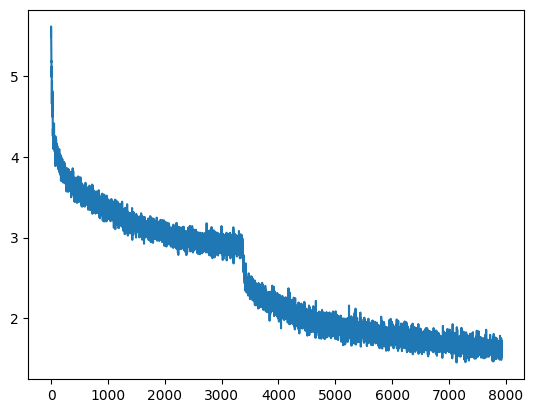

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



TRAIN TRUE: genre: deephouse, techno, house; instrument: bass

TRAIN PRED-HF: <|endoftext|>guitar, synthesizer<|endoftext|>

TRAIN PRED-OUR: synthesizer, synthesizer<|endoftext|>guitar, drums, drums, synthesizer; mood/theme: 
heavy<|endoftext|> dream<|endoftext|>, relaxing<|endoftext|><|endoftext|>, light<|endoftext|>paced, 
deep<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>ward<|e
ndoftext|><|endoftext|>, adventure, 
dark<|endoftext|><|endoftext|>tech<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|e
ndoftext|>val<|endoftext|><|endoftext|><|endoftext|>

TEST TRUE: genre: funk, dance, electronic, house, disco

TEST PRED-HF: <|endoftext|>beat; instrument: synthesizer, bass, drums, electricpiano, electricguitar, synthesizer, 
electricguitar, drummachine, electricguitar; mood/theme: energetic<|endoftext|>

TEST PRED-OUR: beat; instrument: synthesizer, bass, electricguitar, drums, bass, keyboard, bass; mood/theme: early,
energetic, happy, deep, playful, passionate<|endoftext|> positive<|endoftext|> happy<|endoftext|>, 
energetic<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|
endoftext|><|endoftext|><|endoftext|><|endoftext|> relaxing<|endoftext|><|endoftext|>video<|endoftext|> 
relaxing<|endoftext|>,

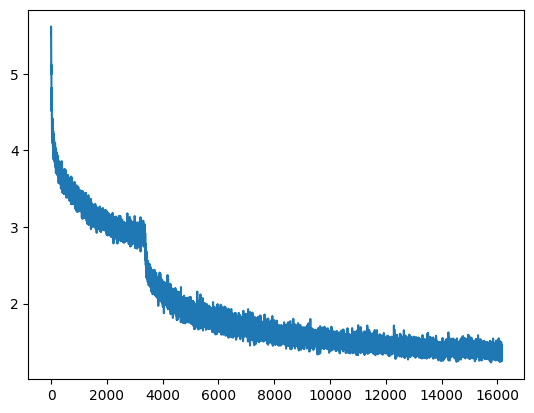

TRAIN TRUE: genre: pop; instrument: bass, computer, acousticguitar, electricguitar, drums

TRAIN PRED-HF: <|endoftext|>guitar, electricguitar<|endoftext|>

TRAIN PRED-OUR: bass, bass<|endoftext|> guitar, drums, computer, guitar<|endoftext|> amps<|endoftext|> trombone, 
viola, hiton, drums, drums, drums<|endoftext|>guitar, synthesizer<|endoftext|>guitar<|endoftext|> horn, 
harp<|endoftext|>ban, drums<|endoftext|> voxico<|endoftext|>guitar, harp<|endoftext|> violin, drums

TEST TRUE: genre: rock, bossanova, alternative; mood/theme: brazil

TEST PRED-HF: <|endoftext|> melodic<|endoftext|>

TEST PRED-OUR: adjective<|endoftext|> symbolism, meditative<|endoftext|> requireva<|endoftext|> summer<|endoftext|>
2012<|endoftext|> gothic<|endoftext|> gothic<|endoftext|> theme: light<|endoftext|><|endoftext|> 
america<|endoftext|> inspirational<|endoftext|> christening<|endoftext|><|endoftext|> cabaret<|endoftext|> 
dream<|endoftext|> christmas<|endoftext|>o<|endoftext|>ard<|endoftext|><|endoftext|>fance<|endoftext|><|endoftext|>
meditative<|endoftext|><|endoftext|>itarian, passionate<|endoftext|><|endoftext|><|endoftext|><|endoftext|>

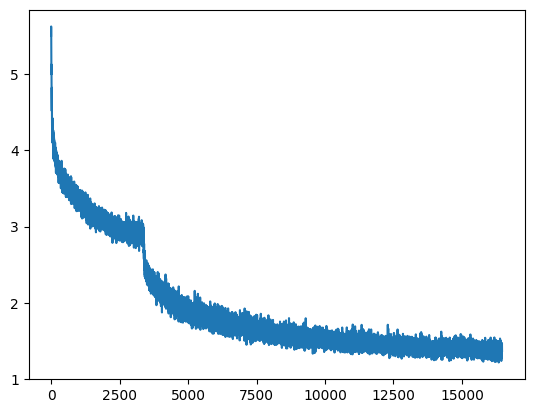

TRAIN TRUE: genre: classical; instrument: orchestra, drummachine, sampler, synthesizer, electricpiano; mood/theme: 
epic

TRAIN PRED-HF: <|endoftext|><|endoftext|>

TRAIN PRED-OUR: <|endoftext|> christmas<|endoftext|><|endoftext|><|endoftext|> enchantovy, fun, summer<|endoftext|>
christmas<|endoftext|> christmas<|endoftext|> christmas<|endoftext|> holiday<|endoftext|> 
christmas<|endoftext|><|endoftext|><|endoftext|><|endoftext|> christmas<|endoftext|> 
christening<|endoftext|><|endoftext|> christmas<|endoftext|><|endoftext|> dream<|endoftext|><|endoftext|> 
christmas<|endoftext|> christmas<|endoftext|> christmas<|endoftext|> gothic<|endoftext|>ening<|endoftext|> 
christmas<|endoftext|> christmas

TEST TRUE: genre: indie, indiepop, pop, rock, alternative; instrument: bass, electricguitar, synthesizer

TEST PRED-HF: <|endoftext|> guitar; mood/theme: energetic<|endoftext|>

TEST PRED-OUR: sampler, acousticbassguitar, voice, vocals, drums, bass, synthesizer<|endoftext|>pan<|endoftext|> 
fancier, electricpiano, electricpiano, claron<|endoftext|> electricpiano, trumpet, synthesizer<|endoftext|>, drums,
melodicorgan<|endoftext|>fish; mood/theme: mellow, grand<|endoftext|>

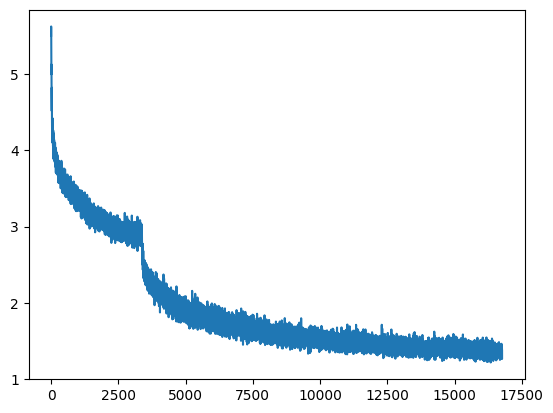

Unfroze gpt2


  0%|          | 0/3366 [00:00<?, ?it/s]

TRAIN TRUE: genre: dance, pop, electronic; mood/theme: christmas, happy

TRAIN PRED-HF: <|endoftext|> christmas<|endoftext|>

TRAIN PRED-OUR: christmas<|endoftext|> christmas<|endoftext|><|endoftext|> christmas, meditative, winter, 
holiday<|endoftext|> christmas, romantic<|endoftext|> rich<|endoftext|> summer, sponsorship, 
christmas<|endoftext|>blue<|endoftext|> christmas, holiday<|endoftext|> 
christmas<|endoftext|><|endoftext|><|endoftext|> christmas<|endoftext|> 
christmas<|endoftext|><|endoftext|><|endoftext|><|endoftext|>image, 
christmas<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> christmas<|endoftext|>

TEST TRUE: genre: ambient, electropop

TEST PRED-HF: <|endoftext|>, soundtrack; instrument: synthesizer, piano, synthesizer; mood/theme: 
relaxing<|endoftext|>

TEST PRED-OUR: , jazz; instrument: saxophone, guitar<|endoftext|> guitar, guitar; mood/theme: 
melodic<|endoftext|><|endoftext|> romantic<|endoftext|>, epic<|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
melodic<|endoftext|> 
lonely<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
energetic<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
calm<|endoftext|> 
instrumental<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|
>

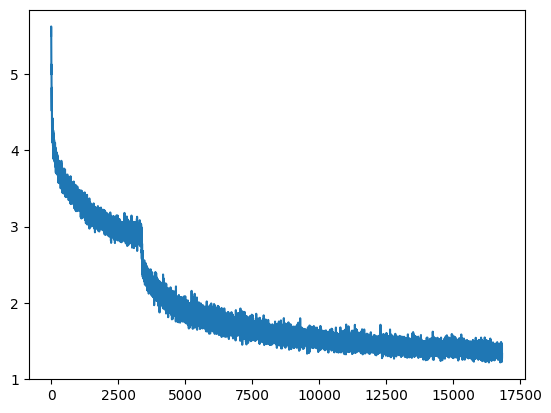

TRAIN TRUE: genre: jazz, improvisation; instrument: piano

TRAIN PRED-HF: <|endoftext|>guitar; mood/theme: melodic<|endoftext|>

TRAIN PRED-OUR: trumpet, piano, acousticguitar; mood/theme: film<|endoftext|> soundscape<|endoftext|> calm, 
sea<|endoftext|> theme: documentary, dark<|endoftext|> melodic<|endoftext|>, 
deep<|endoftext|><|endoftext|><|endoftext|>ening, slow<|endoftext|>, film<|endoftext|> 
fun<|endoftext|><|endoftext|> warm, meditative<|endoftext|>ening, acoustic<|endoftext|><|endoftext|><|endoftext|> 
soundscape<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>

TEST TRUE: genre: score, soundtrack; mood/theme: emotional, film

TEST PRED-HF: <|endoftext|> christmas, christmas, christmas, christmas, christmas, christmas, christmas, christmas,
christmas, christmas, christmas, christmas, christmas, christmas, christmas, christmas, christmas, christmas, 
christmas, christmas, christmas<|endoftext|>

TEST PRED-OUR: <|endoftext|> romantic<|endoftext|> meditative<|endoftext|> love<|endoftext|> idus<|endoftext|>| 
sad<|endoftext|>epic, corporate, positive<|endoftext|><|endoftext|> relaxing<|endoftext|> carina<|endoftext|> 
sunny<|endoftext|><|endoftext|> soundscape<|endoftext|> motivational<|endoftext|> 
technological<|endoftext|><|endoftext|> theme: sad<|endoftext|> angelic<|endoftext|><|endoftext|>, 
motivational<|endoftext|><|endoftext|>, joyful, ballad<|endoftext|> relaxing, advertising, philosophy<|endoftext|> 
dream<|endoftext|>

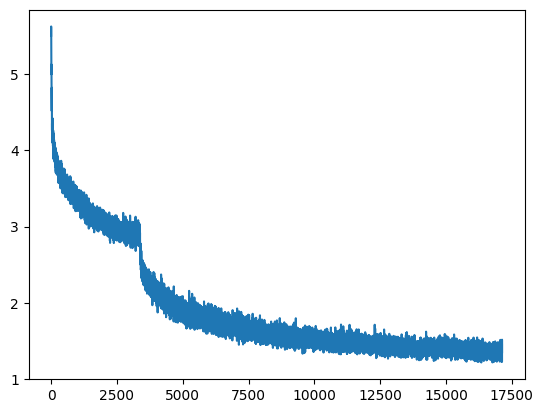

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



TEST PRED-OUR: tech, advertising, heavy<|endoftext|> meditative<|endoftext|> sweet<|endoftext|> road<|endoftext|> 
soundscape<|endoftext|> glamour<|endoftext|> fast<|endoftext|><|endoftext|>ard<|endoftext|><|endoftext|>, 
energetic<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
commercial<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>en<|endoftext|><|endoftext|><|endoftext|
><|endoftext|><|endoftext|>ward<|endoftext|>, 
relaxing<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
coastal<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>

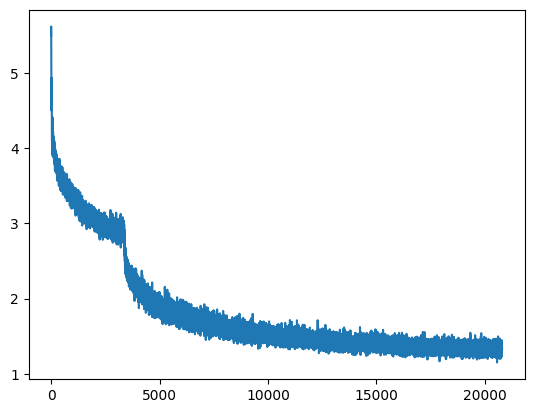

TRAIN TRUE: genre: alternativerock, lofi, indie, folk, rock; instrument: violin, acousticguitar, voice, bass

TRAIN PRED-HF: <|endoftext|> electricguitar, drums, electricguitar; mood/theme: melodic<|endoftext|>

TRAIN PRED-OUR: chroma<|endoftext|>guitar, drums, electricguitar, synthesizer<|endoftext|> drums<|endoftext|> 
acousticguitar<|endoftext|> cymbal, hammond<|endoftext|> guitar<|endoftext|>(guitar, voicepe, 
drums<|endoftext|>bassguitar, acousticguitar, synthesizer<|endoftext|>bassguitar, bell

TEST TRUE: genre: soundtrack, classical; instrument: piano, synthesizer; mood/theme: film, emotional

TEST PRED-HF: <|endoftext|> movie<|endoftext|>

TEST PRED-OUR: soft, hopeful<|endoftext|> movie<|endoftext|> film<|endoftext|> dream<|endoftext|> 
relaxing<|endoftext|> story, nature<|endoftext|> romantic<|endoftext|> summer<|endoftext|> movie, adventure, 
documentary<|endoftext|> theme: film<|endoftext|><|endoftext|> patriotic, film, deep<|endoftext|> 
optimistic<|endoftext|> dream<|endoftext|> happy<|endoftext|> film<|endoftext|> film<|endoftext|> 
summer<|endoftext|><|endoftext|> film<|endoftext|> commercial<|endoftext|> romantic<|endoftext|> 
inspiration<|endoftext|> cool<|endoftext|> revisational<|endoftext|> love

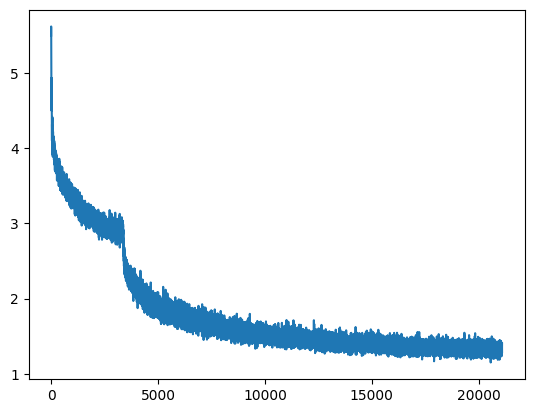

TRAIN TRUE: genre: rock, alternative, indie

TRAIN PRED-HF: <|endoftext|> metal; instrument: electricguitar, drums, bass, electricguitar, electricguitar, 
electricguitar; mood/theme: melodic<|endoftext|>

TRAIN PRED-OUR: grunge, indie, rocknroll, indie; instrument: guitar<|endoftext|> guitar, vocal, 
xylophone<|endoftext|> harp<|endoftext|> bass, drums, bass, drums, drums, bass<|endoftext|> horn<|endoftext|> 
electricguitar, drums, drums<|endoftext|> bass, drums<|endoftext|>guitar, bass, bass, drums, synthes

TEST TRUE: genre: easylistening, lounge, electronic

TEST PRED-HF: <|endoftext|>beat; instrument: synthesizer, bass, synthesizer; mood/theme: energetic<|endoftext|>

TEST PRED-OUR: highhouse, dance; instrument: bass, computer<|endoftext|> accordion, bell, keyboard, 
electricguitar<|endoftext|>pan, synthesizer<|endoftext|> electricguitar<|endoftext|> piano<|endoftext|> 
ecm<|endoftext|>guitar<|endoftext|>bass, piano, synthesizer, keyboard, house, drums, viola; mood/theme: 
entertaining,

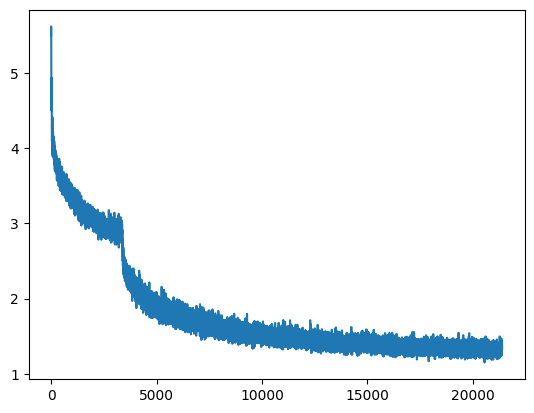

TRAIN TRUE: genre: punkrock, rock

TRAIN PRED-HF: <|endoftext|> metal; instrument: bass, drums, electricguitar, drums, electricguitar, electricguitar,
electricguitar, electricguitar<|endoftext|>

TRAIN PRED-OUR: metal, rock<|endoftext|>guitar<|endoftext|>strument: guitar, bass, synthesizer<|endoftext|>guitar, 
acousticguitar<|endoftext|>guitar<|endoftext|> bass<|endoftext|>guitar<|endoftext|> horn<|endoftext|>guitar, 
drums<|endoftext|>guitar<|endoftext|>guitar<|endoftext|> soundorgan<|endoftext|> bass, 
drummachine<|endoftext|>guitar,

TEST TRUE: genre: easylistening, newage; instrument: metallophone, glockenspiel; mood/theme: commercial, 
documentary, children, soft

TEST PRED-HF: <|endoftext|> motivational, uplifting, uplifting<|endoftext|>

TEST PRED-OUR: relaxing, calm<|endoftext|> inspiring<|endoftext|> drama, sweet, environmental<|endoftext|> 
film<|endoftext|> choral<|endoftext|> politics<|endoftext|> inspirational, sweet, christmas<|endoftext|> 
rhodes<|endoftext|> light<|endoftext|> forest<|endoftext|> peaceful, adventure<|endoftext|> summer, 
autumn<|endoftext|> soundscape<|endoftext|> holiday, brormoween<|endoftext|><|endoftext|> holiday<|endoftext|> 
wake<|endoftext|> christmas<|endoftext|> technohome<|endoftext|>

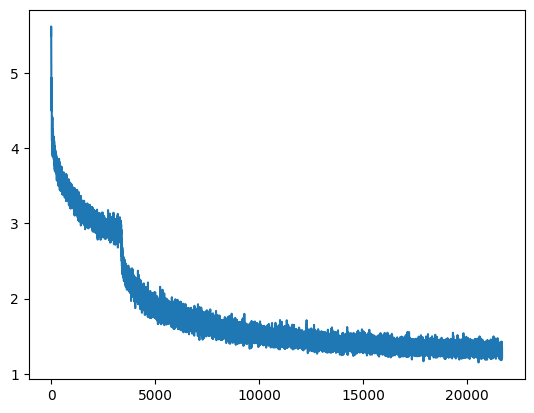

TRAIN TRUE: genre: lounge, hiphop, chillout; mood/theme: arabic

TRAIN PRED-HF: <|endoftext|> dream, dream<|endoftext|>

TRAIN PRED-OUR: anime, space<|endoftext|>peace<|endoftext|>, meditative<|endoftext|> bric<|endoftext|><|endoftext|>
relaxing<|endoftext|>ward<|endoftext|><|endoftext|><|endoftext|> 
brazil<|endoftext|><|endoftext|>uddle<|endoftext|>ward<|endoftext|> holiday<|endoftext|> 
linky<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>ening<|endoftext|><|endoftext|><|endoftext|>,
drone, film<|endoftext|> conspirovy, film<|endoftext|><|endoftext|><|endoftext|>, 
christmas<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>road<|endoftext|>

TEST TRUE: genre: electronic, experimental, alternative

TEST PRED-HF: <|endoftext|>; instrument: synthesizer; mood/theme: dark<|endoftext|>

TEST PRED-OUR: technop<|endoftext|>bamp, trance; mood/theme: meditative<|endoftext|>imensional, meditative, 
film<|endoftext|> dream<|endoftext|> dream<|endoftext|> drama<|endoftext|> summer<|endoftext|> melodic<|endoftext|>
relaxing<|endoftext|><|endoftext|> technica<|endoftext|><|endoftext|><|endoftext|> 
melodic<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>ing<|endoftext|>ist<|endoftext
|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>ening<|en
doftext|><|endoftext|>

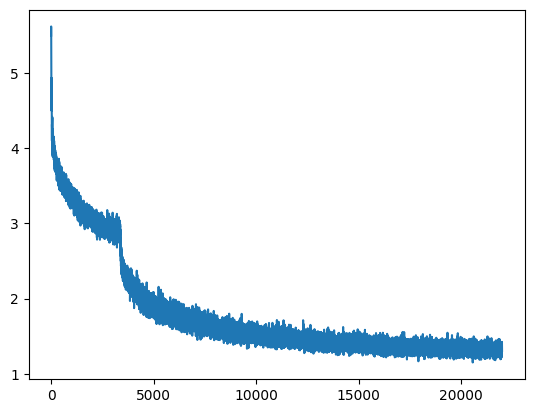

TRAIN TRUE: genre: electropop, synthpop, technoindustrial; mood/theme: light

TRAIN PRED-HF: <|endoftext|> technomic<|endoftext|>

TRAIN PRED-OUR: val<|endoftext|>y<|endoftext|> technos<|endoftext|> hopeful, epic<|endoftext|> film<|endoftext|> 
wonder<|endoftext|> meditative<|endoftext|> commercial, meditative<|endoftext|> energetic<|endoftext|> 
inside<|endoftext|> ambiental<|endoftext|> energetic<|endoftext|> dream<|endoftext|> standow<|endoftext|> 
classical<|endoftext|> holiday<|endoftext|> calm, summer<|endoftext|> fun<|endoftext|> soundscape<|endoftext|> 
subdued<|endoftext|> early<|endoftext|> beautiful<|endoftext|> brazil<|endoftext|> summer<|endoftext|> 
cycleic<|endoftext|>

TEST TRUE: genre: pop, rap, house, eurodance

TEST PRED-HF: <|endoftext|>beat; instrument: synthesizer; mood/theme: melodic<|endoftext|>

TEST PRED-OUR: <|endoftext|>beat; instrument: drums, electricguitar, bass, drummachine; mood/theme: 
melodic<|endoftext|> melodic<|endoftext|>ward, advertising, deep<|endoftext|> summer, upbeat<|endoftext|> 
nuts<|endoftext|> theme: film<|endoftext|> sport<|endoftext|> summer<|endoftext|> relaxing<|endoftext|> 
summer<|endoftext|> deep<|endoftext|><|endoftext|><|endoftext|><|endoftext|> summer<|endoftext|><|endoftext|> 
summer<|endoftext|> art<|endoftext|><|endoftext|>

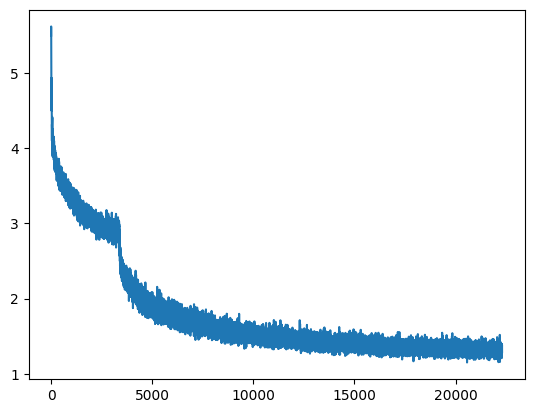

TRAIN TRUE: genre: rock, newage; instrument: piano, guitar; mood/theme: sad, inspiring, hopeful, motivational, 
bright

TRAIN PRED-HF: <|endoftext|> inspiring, uplifting, uplifting, uplifting, uplifting<|endoftext|>

TRAIN PRED-OUR: happy<|endoftext|> quiet<|endoftext|> melodic<|endoftext|> energetic, adventure<|endoftext|> 
dark<|endoftext|> meditative<|endoftext|><|endoftext|> soundscape<|endoftext|><|endoftext|><|endoftext|>; 
mood/theme: peaceful, calm<|endoftext|> background<|endoftext|><|endoftext|> soundscape<|endoftext|><|endoftext|> 
motivational<|endoftext|><|endoftext|> exciting<|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
happy<|endoftext|> film<|endoftext|> groovy<|endoftext|> summer<|endoftext|>, inspiring<|endoftext|> 
technoo<|endoftext|><|endoftext|><|endoftext|><|endoftext|>

TEST TRUE: genre: poprock

TEST PRED-HF: <|endoftext|> rock, poprock; instrument: electricguitar, drums, bass, electricguitar, electricguitar;
mood/theme: energetic<|endoftext|>

TEST PRED-OUR: triphop, triphop, rock; instrument: bass, drums, bass, synthesizer, guitar<|endoftext|> drummachine,
synthesizer, electricguitar, guitar, synthesizer, synthesizer, bass, electricguitar, doublebass<|endoftext|> 
drummachine, drumsmachine, synthesizer, acousticguit

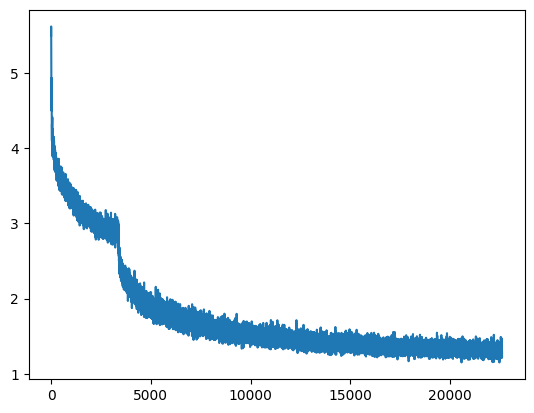

TRAIN TRUE: genre: pop, soundtrack; instrument: electricpiano, pipeorgan, electricguitar, keyboard, bass, 
classicalguitar, voice, piano; mood/theme: humor, groovy

TRAIN PRED-HF: <|endoftext|> summer<|endoftext|>

TRAIN PRED-OUR: soundscape, cheerful<|endoftext|> summer<|endoftext|> summer<|endoftext|> 
autumn<|endoftext|><|endoftext|><|endoftext|> summer<|endoftext|><|endoftext|><|endoftext|> 
summer<|endoftext|><|endoftext|> bright<|endoftext|> summer<|endoftext|><|endoftext|> summer<|endoftext|>, 
strong<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> and holiday<|endoftext|> 
summer<|endoftext|> theme: beach<|endoftext|><|endoftext|><|endoftext|> summer<|endoftext|> 
summer<|endoftext|><|endoftext|> soundscape<|endoftext|><|endoftext|><|endoftext|>, inspiring<|endoftext|> 
nature<|endoftext|>ing<|endoftext|> positive<|endoftext|>

TEST TRUE: instrument: synthesizer, sampler, piano

TEST PRED-HF: <|endoftext|>guitar; mood/theme: happy<|endoftext|>

TEST PRED-OUR: >guitar, synthesizer, piano drums<|endoftext|>; mood/theme: happy<|endoftext|> 
soundscape<|endoftext|> 
romantic<|endoftext|><|endoftext|><|endoftext|><|endoftext|>ward<|endoftext|><|endoftext|><|endoftext|><|endoftext|
><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>jender<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|
endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
<|endoftext|><|endoftext|><|endoftext|><|endoftext|>

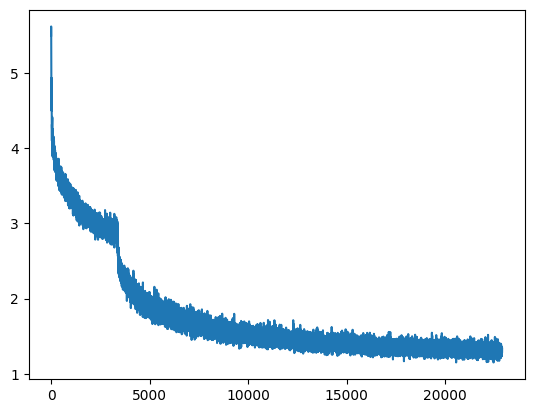

TRAIN TRUE: genre: orchestral, classical, baroque, choral

TRAIN PRED-HF: <|endoftext|> soundtrack; mood/theme: film<|endoftext|>

TRAIN PRED-OUR: guitar, chanson; instrument: guitar, clarinet, violin, cello, oboe, guitar, violin, doublebass; 
mood/theme: landscape<|endoftext|> music, sad, film, film film<|endoftext|> beautiful<|endoftext|> 
romantic<|endoftext|> attention<|endoftext|> soundscape<|endoftext|> positive, cute<|endoftext|> 
inspiring<|endoftext|> cvp509<|endoftext|> child

TEST TRUE: genre: technoindustrial, powerpop; instrument: synthesizer

TEST PRED-HF: <|endoftext|> synthesizer; mood/theme: energetic<|endoftext|>

TEST PRED-OUR: bass; mood/theme: peaceful<|endoftext|><|endoftext|> dark<|endoftext|> heavy<|endoftext|> 
futuristic<|endoftext|> dream<|endoftext|> ambiental<|endoftext|> dream<|endoftext|> dark<|endoftext|> 
hopeful<|endoftext|><|endoftext|> technobic<|endoftext|> bright<|endoftext|> beautiful<|endoftext|><|endoftext|> 
quiet<|endoftext|> summer<|endoftext|> soft<|endoftext|>val<|endoftext|>enn<|endoftext|> industrial<|endoftext|> 
theme: dark<|endoftext|> melodic<|endoftext|> ballot<|endoftext|>ening<|endoftext|> meditative<|endoftext|>leg

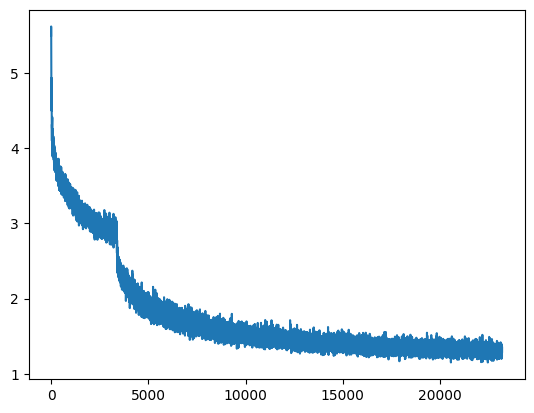

TRAIN TRUE: genre: industrial, metal, score, soundtrack, dubstep, electronic; mood/theme: heavy

TRAIN PRED-HF: <|endoftext|> dark<|endoftext|>

TRAIN PRED-OUR: playful<|endoftext|> video<|endoftext|> focused, epic, adventure, sad, motivational<|endoftext|> 
soundscape<|endoftext|> documentary<|endoftext|> melodic<|endoftext|> sustainable<|endoftext|> high, inspiring, 
film<|endoftext|><|endoftext|><|endoftext|> holiday, slow, bringer<|endoftext|> technotech<|endoftext|> 
dream<|endoftext|> meditation<|endoftext|><|endoftext|> mystical<|endoftext|> 
summer<|endoftext|><|endoftext|>ge<|endoftext|>, film<|endoftext|> documentary<|endoftext|> 
money<|endoftext|><|endoftext|><|endoftext|> summer

TEST TRUE: genre: atmospheric, downtempo, electronic; instrument: guitar, drums, piano

TEST PRED-HF: <|endoftext|> synthesizer; mood/theme: ambiental<|endoftext|>

TEST PRED-OUR: rhodes, bass, synthesizer, sampler<|endoftext|> bass, accordion, sampler; mood/theme: heavy, 
dark<|endoftext|> dark<|endoftext|> deep, energetic<|endoftext|> energetic<|endoftext|> summer, 
adventure<|endoftext|><|endoftext|> summer<|endoftext|> film<|endoftext|> reflective<|endoftext|> 
autumn<|endoftext|> zen<|endoftext|> coastal, energy<|endoftext|> metal<|endoftext|> summer<|endoftext|> 
summer<|endoftext|> summer<|endoftext|>

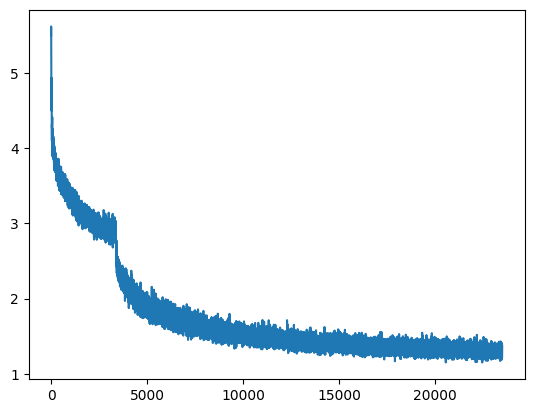

Unfroze gpt2


  0%|          | 0/3366 [00:00<?, ?it/s]

TRAIN TRUE: genre: electronic, house, dance, experimental; mood/theme: cool

TRAIN PRED-HF: <|endoftext|> melodic<|endoftext|>

TRAIN PRED-OUR: relaxing<|endoftext|> smooth<|endoftext|> relaxing<|endoftext|> melodic, relaxing<|endoftext|> 
melodic<|endoftext|>berg<|endoftext|><|endoftext|>ytoway<|endoftext|><|endoftext|>ening<|endoftext|> 
summer<|endoftext|> 
summeragoo<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>ptical<|endoft
ext|> summer<|endoftext|><|endoftext|><|endoftext|> arty<|endoftext|><|endoftext|> 
technoh<|endoftext|>cy<|endoftext|>ge<|endoftext|><|endoftext|>ard<|endoftext|><|endoftext|> 
dream<|endoftext|><|endoftext|> summer, christ

TEST TRUE: genre: popfolk, folk; instrument: acousticguitar, djembe, violin, piano, flute, accordion

TEST PRED-HF: <|endoftext|> bass, acousticguitar, electricguitar, acousticguitar; mood/theme: folkrock<|endoftext|>

TEST PRED-OUR: mandolin<|endoftext|> violin, oboe, strings<|endoftext|> guitar, acousticbass, violin, cello, 
ukulele, synthesizer, hammond, voice, acousticguitar, trumpet; mood/theme: sad<|endoftext|> upbeat<|endoftext|> 
romantic<|endoftext|><|endoftext|> folkrock<|endoftext|> melodic<|endoftext|>, energetic<|endoftext|> 
marimba<|endoftext|>

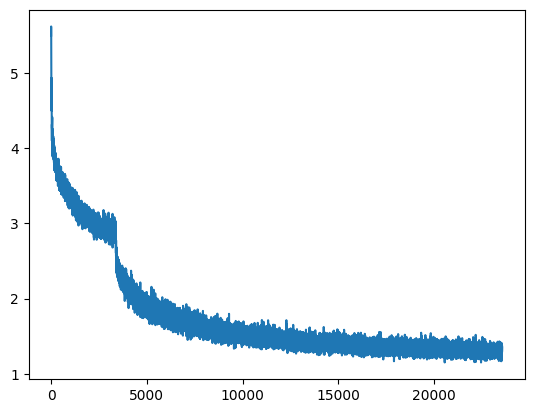

TRAIN TRUE: genre: experimental, electronic, alternative, soundtrack; mood/theme: ambiental

TRAIN PRED-HF: <|endoftext|> melodic<|endoftext|>

TRAIN PRED-OUR: cheer, supporting, driving<|endoftext|> movie, nothing<|endoftext|> film<|endoftext|> 
meditative<|endoftext|> film<|endoftext|> summer, negative<|endoftext|> warm<|endoftext|> 
happy<|endoftext|><|endoftext|> sweet<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
adventure<|endoftext|><|endoftext|>, powerful<|endoftext|> warm<|endoftext|> meditative<|endoftext|><|endoftext|>, 
camp<|endoftext|><|endoftext|><|endoftext|>, passionate, strong, 
film<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, calm<|endoftext|>

TEST TRUE: genre: experimental, electronic, soundtrack; mood/theme: ambiental

TEST PRED-HF: <|endoftext|> soundscape<|endoftext|>

TEST PRED-OUR: dark<|endoftext|> dark<|endoftext|> meditative<|endoftext|> dark<|endoftext|> peaceful<|endoftext|> 
dark<|endoftext|> medicine<|endoftext|> relaxing<|endoftext|> want<|endoftext|> dark<|endoftext|> calm<|endoftext|>
dark<|endoftext|>ward, art<|endoftext|> string<|endoftext|> dark<|endoftext|> summer<|endoftext|> deep<|endoftext|>
dream<|endoftext|> dark<|endoftext|>ad<|endoftext|> dream<|endoftext|> dark<|endoftext|> dark<|endoftext|> is 
dark<|endoftext|> happy<|endoftext|> calm<|endoftext|> documentary<|endoftext|><|endoftext|> vintage<|endoftext|> 
meditative,

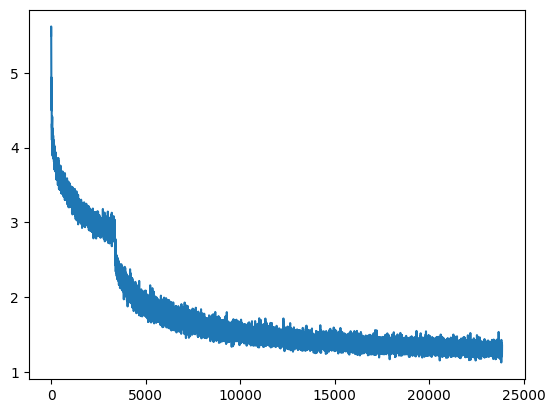

TRAIN TRUE: genre: avantgarde, ambient, experimental; instrument: computer

TRAIN PRED-HF: <|endoftext|> synthesizer; mood/theme: ambiental<|endoftext|>

TRAIN PRED-OUR: electricguitar<|endoftext|> synthesizer, violin, tuba; mood/theme: melodic, relaxing<|endoftext|> 
dark<|endoftext|> film<|endoftext|> dream<|endoftext|> energetic, melancholic<|endoftext|> summer<|endoftext|> 
romantic<|endoftext|> ambiental<|endoftext|> relaxing<|endoftext|> soundscape<|endoftext|> soundscape<|endoftext|> 
dream<|endoftext|> soundscape<|endoftext|> quiet<|endoftext|> love<|endoftext|> beautiful<|endoftext|> 
honey<|endoftext|> hypnotic<|endoftext|>

TEST TRUE: genre: chillout, easylistening, ambient; instrument: bell; mood/theme: inspiring, dramatic, hopeful, 
relaxing, romantic, motivational

TEST PRED-HF: <|endoftext|> uplifting, uplifting, uplifting, uplifting, uplifting, uplifting, uplifting, uplifting,
uplifting, uplifting<|endoftext|>

TEST PRED-OUR: festive, calm, beautiful<|endoftext|> film<|endoftext|> inspiration<|endoftext|> 
commercial<|endoftext|> corporate, motivational<|endoftext|> action, joyful, strong<|endoftext|> film<|endoftext|> 
coastal<|endoftext|> happy<|endoftext|> positive<|endoftext|> inspiring<|endoftext|> corporate, advertising, 
corporate<|endoftext|> reflective<|endoftext|> brina<|endoftext|> green, corporate<|endoftext|> upbeat<|endoftext|>
coastal<|endoftext|> fun<|endoftext|> reminds, advertising<|endoftext|> bands<|endoftext|> christmas<|endoftext|> 
love,

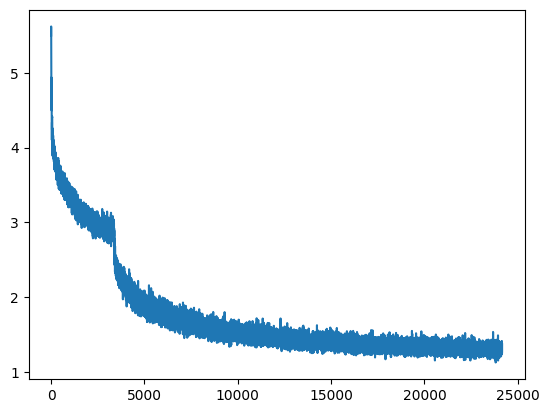

TRAIN TRUE: genre: dance, alternative, funk

TRAIN PRED-HF: <|endoftext|> jazz; instrument: electricguitar, bass, drums, electricguitar, electricguitar; 
mood/theme: melodic<|endoftext|>

TRAIN PRED-OUR: rock; instrument: bass, piano, synthesizer<|endoftext|> drums, electricpiano, electricguitar, 
drums<|endoftext|>bassguitar, electricpiano, electricguitar, electricguitar, electricguitar, bass<|endoftext|> 
brass, drums; mood/theme: action<|endoftext|><|endoftext|><|endoftext|> soundscape

TEST TRUE: genre: chillout, house, easylistening; instrument: keyboard, saxophone, percussion, drums, bass; 
mood/theme: deep, summer, playful

TEST PRED-HF: <|endoftext|> summer, playful, playful, playful, playful, playful, playful, playful, playful, 
playful, playful, playful, playful, playful, playful<|endoftext|>

TEST PRED-OUR: inspiring, film<|endoftext|> summer<|endoftext|>}, snowball, happy, 
adventure<|endoftext|><|endoftext|> summer<|endoftext|> kids<|endoftext|> summer<|endoftext|><|endoftext|>, summer,
happy<|endoftext|><|endoftext|> whims<|endoftext|><|endoftext|> summer<|endoftext|><|endoftext|>, 
meditative<|endoftext|><|endoftext|><|endoftext|><|endoftext|> soundscape<|endoftext|><|endoftext|>, 
inspiring<|endoftext|><|endoftext|> 
dream<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
summer<|endoftext|> melodic<|endoftext|><|endoftext|><|endoftext|> dream

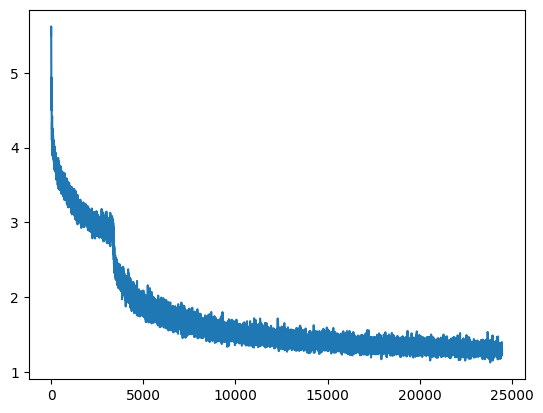

TRAIN TRUE: genre: alternative, acidhouse, electronic; instrument: computer

TRAIN PRED-HF: <|endoftext|> synthesizer; mood/theme: melodic<|endoftext|>

TRAIN PRED-OUR: synthesizer<|endoftext|> sampler<|endoftext|><|endoftext|> synthesizer<|endoftext|>gs; mood/theme: 
energetic, dark<|endoftext|> summer<|endoftext|>ep<|endoftext|> animated<|endoftext|> 
summer<|endoftext|><|endoftext|> summer<|endoftext|> adventure<|endoftext|><|endoftext|><|endoftext|> 
inspiring<|endoftext|><|endoftext|> 
summer<|endoftext|><|endoftext|><|endoftext|><|endoftext|>danger<|endoftext|><|endoftext|> 
summery<|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
sound<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>u<|endoftext|><|endoftext|>, meditative

TEST TRUE: genre: blues, folk, popfolk

TEST PRED-HF: <|endoftext|>>strument: acousticguitar; mood/theme: folkrock<|endoftext|>

TEST PRED-OUR: strument: bass<|endoftext|> acousticguitar, electricguitar, voice, acousticguitar, violin; 
mood/theme: love<|endoftext|> summer<|endoftext|> romantic, romantic<|endoftext|> summer<|endoftext|> drama, carow,
epic<|endoftext|> documentary, nature<|endoftext|> summer, beach<|endoftext|> animated<|endoftext|> summer, 
love<|endoftext|> theme: spiritual<|endoftext|> commercial<|endoftext|>

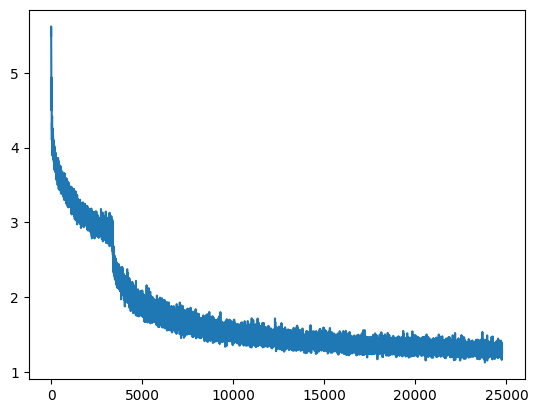

TRAIN TRUE: genre: electronic, lounge, world, ambient, chillout; instrument: synthesizer

TRAIN PRED-HF: <|endoftext|> synthesizer; mood/theme: relaxing<|endoftext|>

TRAIN PRED-OUR: piano<|endoftext|> panflute, drums, synthesizer; mood/theme: energetic<|endoftext|> 
summer<|endoftext|> meditative, deep<|endoftext|> dream<|endoftext|> energetic<|endoftext|> sexy<|endoftext|> 
relaxing<|endoftext|> relaxing<|endoftext|> dream<|endoftext|> dynamic<|endoftext|> summer<|endoftext|> 
summerful<|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
documentary<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
movie<|endoftext|>jazz<|endoftext|><|endoftext|><|endoftext|> 
happy<|endoftext|><|endoftext|><|endoftext|><|endoftext|>

TEST TRUE: genre: orchestral, ambient, avantgarde, experimental

TEST PRED-HF: <|endoftext|> soundtrack; mood/theme: epic<|endoftext|>

TEST PRED-OUR: jazz, classical; instrument: strings, piano, acousticguitar, cello, violin, cello, brass, flute, 
brass; mood/theme: action, sweet<|endoftext|> soundscape<|endoftext|> summer<|endoftext|> soundscape<|endoftext|> 
commercial<|endoftext|> mood/theme: travel<|endoftext|> summer, summer<|endoftext|> film<|endoftext|><|endoftext|> 
festive<|endoftext|>

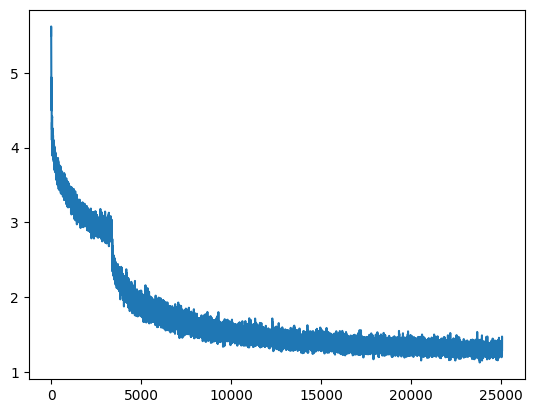

TRAIN TRUE: genre: indie, rock, folk; instrument: cello; mood/theme: melancholic

TRAIN PRED-HF: <|endoftext|> soundscape<|endoftext|>

TRAIN PRED-OUR: warm, love<|endoftext|> powerful<|endoftext|> glossy<|endoftext|> theme: beautiful<|endoftext|> 
powerful<|endoftext|> adventure<|endoftext|> passion, calm, motivational, happy<|endoftext|> need<|endoftext|> 
inspiring<|endoftext|> rain<|endoftext|> inspiring<|endoftext|> innovation<|endoftext|> motivational, dream, 
action, cool<|endoftext|>, action<|endoftext|> melodic<|endoftext|> dream, action<|endoftext|> solid<|endoftext|> 
inspirational<|endoftext|> action<|endoftext|> film<|endoftext|> inspiring, uplifting

TEST TRUE: genre: folk; instrument: banjo, guitar, ukulele

TEST PRED-HF: <|endoftext|> bass, acousticguitar; mood/theme: folkrock<|endoftext|>

TEST PRED-OUR: ukulele<|endoftext|> ukulele, drums<|endoftext|> clarinet, tuba, bongo<|endoftext|> saxophone, 
saxophone<|endoftext|> rhodes, acousticguitar, acousticbassorgan; mood/theme: tropical, christmas<|endoftext|> 
soundtrack<|endoftext|> summer, romantic, celebr, forest<|endoftext|> christmas, film<|endoftext|>

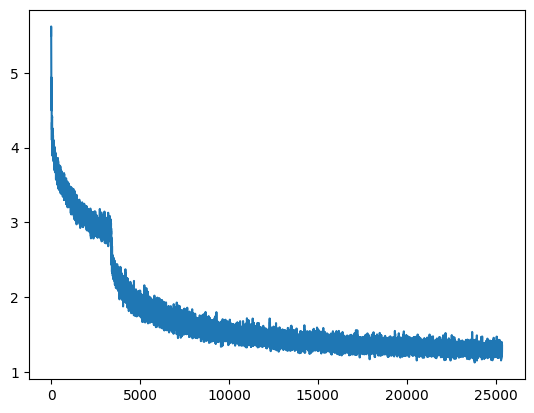

TRAIN TRUE: genre: baroque, classical; instrument: violin

TRAIN PRED-HF: <|endoftext|> piano; mood/theme: sad<|endoftext|>

TRAIN PRED-OUR: drums<|endoftext|> stereo<|endoftext|> keyboard, trumpet, classicalguitar<|endoftext|> 
acousticguitar, synthesizer, violin; mood/theme: cool<|endoftext|> movie<|endoftext|> inspiring, action, 
film<|endoftext|> summer, green<|endoftext|> documentary<|endoftext|><|endoftext|> curving<|endoftext|> 
summer<|endoftext|><|endoftext|><|endoftext|> happy<|endoftext|><|endoftext|> 
boat<|endoftext|><|endoftext|><|endoftext|><|endoftext|> atmospheric<|endoftext|> soundscape<|endoftext|>

TEST TRUE: genre: pop, singersongwriter

TEST PRED-HF: <|endoftext|> jazz; instrument: piano, electricguitar, acousticbassguitar; mood/theme: 
love<|endoftext|>

TEST PRED-OUR: singersongwriter, banjo; instrument: piano, bass, melodicguitar, electricguitar<|endoftext|>, 
violin<|endoftext|> tourbee<|endoftext|> acousticguitar, drums<|endoftext|> synthesizer<|endoftext|> 
horn<|endoftext|> cello, violin<|endoftext|> acousticguitar, acousticguitar, bass; mood/theme: mel

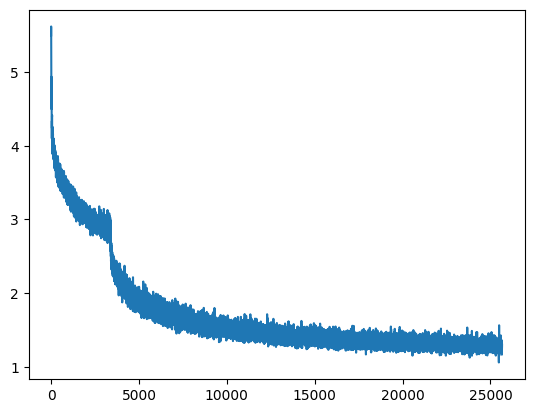

TRAIN TRUE: genre: easylistening, reggae; instrument: organ, electricguitar

TRAIN PRED-HF: <|endoftext|> bass, drums, electricguitar; mood/theme: energetic<|endoftext|>

TRAIN PRED-OUR: electricpiano<|endoftext|> clarinet, percussion, guitar<|endoftext|> guitar<|endoftext|> bass, 
electricguitar, piano<|endoftext|> ***<|endoftext|>, drums<|endoftext|><|endoftext|> piano<|endoftext|>; 
mood/theme: dark<|endoftext|>, happy, fun<|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
commercial<|endoftext|><|endoftext|> summer<|endoftext|><|endoftext|><|endoftext|>, 
advertising<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
g

TEST TRUE: genre: classical; instrument: oboe, pipeorgan, cvp509, piano, drums

TEST PRED-HF: <|endoftext|> flute, violin; mood/theme: melodic<|endoftext|>

TEST PRED-OUR: horn, harp, cello, lead, trombone, doublebass, ukulele, harp, strings, cello, piano; mood/theme: 
soft, documentary, cool<|endoftext|> television<|endoftext|> romantic<|endoftext|><|endoftext|><|endoftext|> 
romantic<|endoftext|> romantic<|endoftext|> bricolat<|endoftext|> romantic<|endoftext|> dream, animated, 
romantic<|endoftext|>

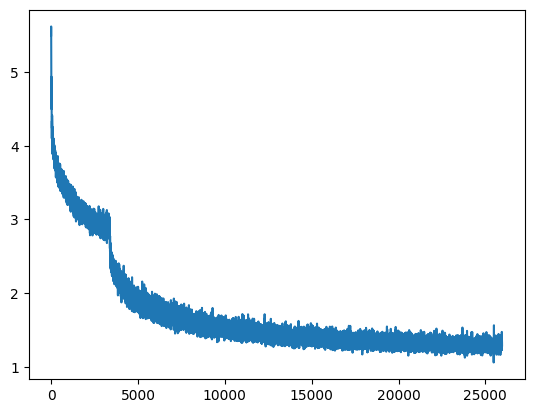

TRAIN TRUE: genre: reggae, dancehall; mood/theme: north

TRAIN PRED-HF: <|endoftext|> summer<|endoftext|>

TRAIN PRED-OUR: chillout, energetic<|endoftext|> relaxing<|endoftext|> commercial<|endoftext|><|endoftext|> 
summer<|endoftext|><|endoftext|>ward<|endoftext|>y<|endoftext|><|endoftext|>ongwriter<|endoftext|><|endoftext|>, 
summer<|endoftext|><|endoftext|><|endoftext|><|endoftext|>ening<|endoftext|><|endoftext|><|endoftext|><|endoftext|>
<|endoftext|><|endoftext|><|endoftext|>ven<|endoftext|><|endoftext|> 
christmas<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
positive<|endoftext|><|endoftext|><|endoftext|>, 
action<|endoftext|><|endoftext|>ow<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|e
ndoftext|>w

TEST TRUE: genre: electronic, dance, techno, electropop, electrohouse; instrument: synthesizer

TEST PRED-HF: <|endoftext|> synthesizer; mood/theme: energetic<|endoftext|>

TEST PRED-OUR: drummachine, synthesizer, drummachine, synthesizer; mood/theme: film<|endoftext|> 
melodic<|endoftext|><|endoftext|>tech<|endoftext|><|endoftext|><|endoftext|> 
happy<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endo
ftext|><|endoftext|><|endoftext|>vert<|endoftext|><|endoftext|><|endoftext|>ward<|endoftext|> 
summer<|endoftext|><|endoftext|>w<|endoftext|><|endoftext|>, 
dark<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
cool<|endoftext|><|endoftext|><|endoftext|><|endoftext|> summer

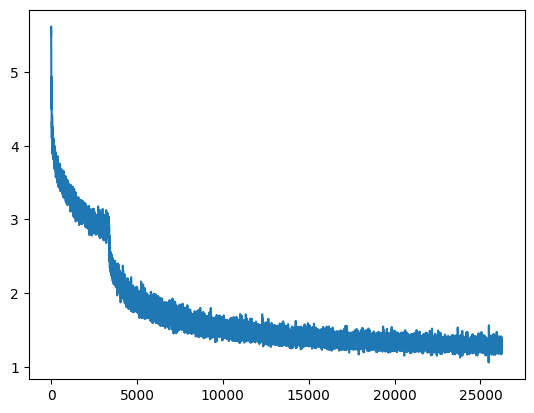

TRAIN TRUE: genre: ambient, indie, soundtrack; instrument: electricguitar

TRAIN PRED-HF: <|endoftext|> synthesizer; mood/theme: relaxing<|endoftext|>

TRAIN PRED-OUR: guitar, synthesizer; mood/theme: powerful, mysterious<|endoftext|> love<|endoftext|> 
melodic<|endoftext|> adventurous<|endoftext|> upbeat, empowering<|endoftext|><|endoftext|> trailer<|endoftext|> 
soundscape<|endoftext|> history, positive<|endoftext|> happy<|endoftext|> 
summer<|endoftext|><|endoftext|><|endoftext|> holiday, documentary<|endoftext|><|endoftext|> romantic<|endoftext|> 
romantic, relaxing<|endoftext|>, sunny, romantic, film<|endoftext|> educational<|endoftext|> 
documentary<|endoftext|><|endoftext|> reflective

TEST TRUE: genre: instrumentalrock, easylistening

TEST PRED-HF: <|endoftext|> hiphop; instrument: guitar, electricguitar, synthesizer, bass, drums, drums, 
synthesizer, bass, electricguitar, drums, electricguitar, synthesizer; mood/theme: energetic<|endoftext|>

TEST PRED-OUR: chillout, electronic<|endoftext|>beat; instrument: piano<|endoftext|> drums<|endoftext|> bass, bass,
bass, drums, electricguitar, piano, cabasa; mood/theme: powerful, 
relaxing<|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
caric<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, motivational<|endoftext|><|endoftext|> 
camp<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> summer<|endoftext|><|endoftext|>

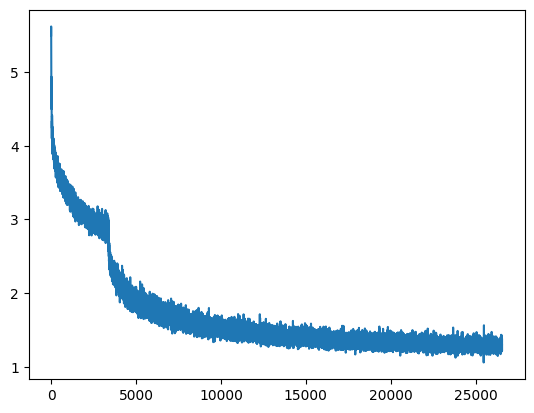

TRAIN TRUE: genre: rock, blues; instrument: guitar

TRAIN PRED-HF: <|endoftext|> electricguitar, drums, electricguitar, electricguitar, bass<|endoftext|>

TRAIN PRED-OUR: bass, electricguitar<|endoftext|> organ, bell<|endoftext|> drums<|endoftext|> 
electricguitar<|endoftext|> synthesizer<|endoftext|> saxophone, drums, acousticbassguitar, synthesizer; mood/theme:
melodic<|endoftext|> film<|endoftext|> happy<|endoftext|><|endoftext|><|endoftext|> dynamic<|endoftext|> 
melodic<|endoftext|><|endoftext|> technomic<|endoftext|>ful<|endoftext|><|endoftext|> love<|endoftext|> metallic

TEST TRUE: genre: chillout, disco, downtempo; instrument: piano, guitar

TEST PRED-HF: <|endoftext|> synthesizer; mood/theme: relaxing<|endoftext|>

TEST PRED-OUR: synthesizer<|endoftext|> bass, synthesizer<|endoftext|> trombone, keyboard, strings<|endoftext|> 
drummachine, synthesizer, keyboard, cello, keyboard, drums, keyboard; mood/theme: quiet, dynamic, 
whims<|endoftext|><|endoftext|> summer<|endoftext|> design<|endoftext|> adventure<|endoftext|><|endoftext|> 
summer<|endoftext|> summer<|endoftext|><|endoftext|><|endoftext|> 
summer<|endoftext|><|endoftext|>en<|endoftext|><|endoftext|> summer

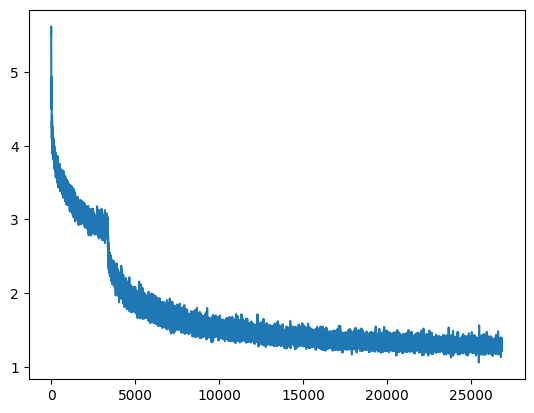

Unfroze gpt2


  0%|          | 0/3366 [00:00<?, ?it/s]

TRAIN TRUE: genre: instrumentalpop, folk

TRAIN PRED-HF: <|endoftext|>>strument: acousticguitar<|endoftext|>

TRAIN PRED-OUR: >jazz, jazz, hardrock<|endoftext|> singersongwriter; instrument: electricguitar, bass, bell, 
drums<|endoftext|> strings, electricguitar<|endoftext|> bass, voice<|endoftext|> rhodes; mood/theme: advertising, 
romantic, spirit<|endoftext|> dynamic<|endoftext|> energy, emotionally<|endoftext|> 
optimistic<|endoftext|><|endoftext|><|endoftext|><|endoftext|> film<|endoftext|>

TEST TRUE: genre: pop

TEST PRED-HF: <|endoftext|>strument: piano; mood/theme: happy, happy, happy, happy<|endoftext|>

TEST PRED-OUR: ew, electronic, singersongwriter; mood/theme: ballad<|endoftext|> motivational<|endoftext|> 
TV<|endoftext|> happy, uplifting<|endoftext|> nature, emotional, uplifting<|endoftext|> meditative, 
uplifting<|endoftext|> inspirational, corporate<|endoftext|> hypnotic<|endoftext|> 
dream<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> drama<|endoftext|><|endoftext|>, 
documentary<|endoftext|>, inspiring<|endoftext|><|endoftext|> ad<|endoftext|><|endoftext|><|endoftext|>

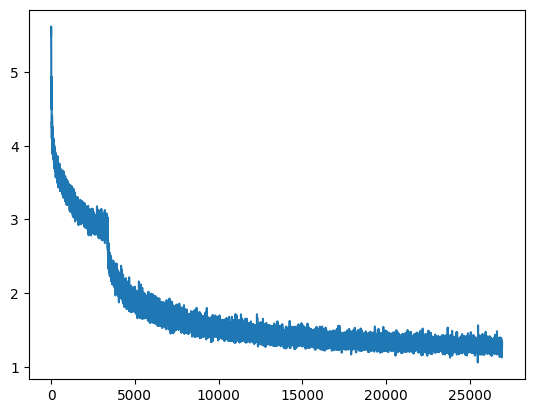

TRAIN TRUE: genre: funk, soundtrack, triphop, electronic; instrument: electricguitar, tambourine, acousticguitar, 
sampler, drums; mood/theme: upbeat, driving, happy

TRAIN PRED-HF: <|endoftext|> melodic<|endoftext|>

TRAIN PRED-OUR: <|endoftext|> upbeat<|endoftext|><|endoftext|> playful, upbeat<|endoftext|> motivational, playful, 
corporate<|endoftext|> composed<|endoftext|> melodic<|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
motivational<|endoftext|> melodic<|endoftext|> 
need<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endof
text|> 
soundscape<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>cy<|endoftext|
> christmas<|endoftext|> summer<|endoftext|><|endoftext|><|endoftext|><|endoftext|> summer<|endoftext|> 
sound<|endoftext|> holiday<|endoftext|> theme<|endoftext|>

TEST TRUE: genre: classical; instrument: bassoon; mood/theme: happy

TEST PRED-HF: <|endoftext|> melodic<|endoftext|>

TEST PRED-OUR: festive<|endoftext|> summer, happy<|endoftext|> nature, love<|endoftext|> love<|endoftext|> 
summer<|endoftext|> christmas<|endoftext|> doll<|endoftext|> christmas<|endoftext|> 
summer<|endoftext|>short<|endoftext|> greeting<|endoftext|> happy<|endoftext|> soundscape<|endoftext|> 
soundscape<|endoftext|> graphic<|endoftext|>3<|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
love<|endoftext|><|endoftext|> summer<|endoftext|> soundscape<|endoftext|><|endoftext|> dream<|endoftext|> 
glockening<|endoftext|> romantic<|endoftext|><|endoftext|><|endoftext|> bright<|endoftext|>

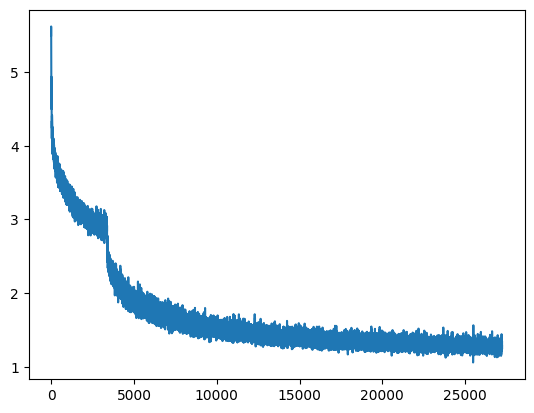

TRAIN TRUE: genre: ambient, soundtrack; mood/theme: sad, melancholic

TRAIN PRED-HF: <|endoftext|> theme: emotional, emotional, emotional, emotional, emotional, emotional, 
emotional<|endoftext|>

TRAIN PRED-OUR: melodic<|endoftext|> holiday, romantic<|endoftext|> emotional<|endoftext|> inspiring, 
socitative<|endoftext|> sad<|endoftext|> design<|endoftext|> rich<|endoftext|> nostalgic, christmas<|endoftext|> 
inspiring<|endoftext|> dream<|endoftext|> hope, inspiring<|endoftext|> rhodes<|endoftext|> dream<|endoftext|> 
holiday<|endoftext|> family<|endoftext|>} commercial<|endoftext|> dream<|endoftext|><|endoftext|> 
romantic<|endoftext|> film<|endoftext|> music<|endoftext|> dream<|endoftext|><|endoftext|> summer<|endoftext|> 
christmas<|endoftext|> romantic

TEST TRUE: genre: dubstep, ambient, house

TEST PRED-HF: <|endoftext|>; instrument: synthesizer; mood/theme: energetic<|endoftext|>

TEST PRED-OUR: cyone<|endoftext|>>, dance, electronic; instrument: synthesizer; mood/theme: ambiental<|endoftext|> 
sad<|endoftext|> dream<|endoftext|> melodic<|endoftext|> documentary, france<|endoftext|> summer<|endoftext|> 
melodic<|endoftext|> summer<|endoftext|> romantic, hypnotic<|endoftext|> summer<|endoftext|>, 
christmas<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
string<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>

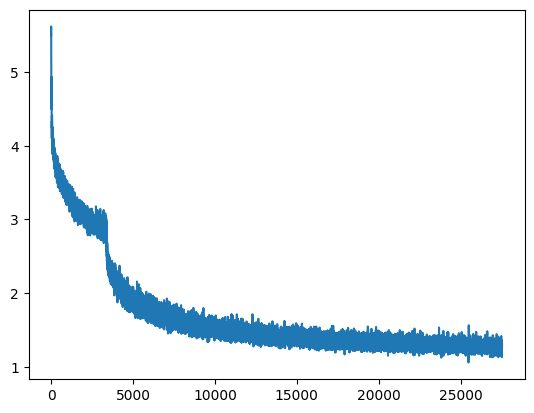

TRAIN TRUE: genre: ambient, electroambient; instrument: synthesizer, computer; mood/theme: zen

TRAIN PRED-HF: <|endoftext|> soundscape<|endoftext|>

TRAIN PRED-OUR: music, stance<|endoftext|> meditative<|endoftext|> dream<|endoftext|> futuristic<|endoftext|> 
dream<|endoftext|> product<|endoftext|> fun<|endoftext|> relaxing<|endoftext|> dark<|endoftext|> dream<|endoftext|>
melodic<|endoftext|> sunny<|endoftext|> dream<|endoftext|> dancefloor<|endoftext|> dream<|endoftext|> 
dream<|endoftext|> dream<|endoftext|> dream<|endoftext|><|endoftext|> dream<|endoftext|> dream<|endoftext|> 
dream<|endoftext|> dream<|endoftext|> soundscape, hypnotic<|endoftext|> classicalgart<|endoftext|>cy<|endoftext|> 
dream<|endoftext|>

TEST TRUE: genre: poprock; instrument: strings

TEST PRED-HF: <|endoftext|> bass, drums, electricguitar, electricguitar; mood/theme: energetic<|endoftext|>

TEST PRED-OUR: piano, acousticguitar, electricguitar, strings, bass; mood/theme: emotional, game<|endoftext|> 
film<|endoftext|> melodic, game<|endoftext|> film<|endoftext|> childhood<|endoftext|> drama<|endoftext|> 
music<|endoftext|> love<|endoftext|> soundscape<|endoftext|><|endoftext|> impia<|endoftext|> drazil<|endoftext|> 
film, film<|endoftext|> melodic<|endoftext|> love<|endoftext|>, uplifting<|endoftext|>

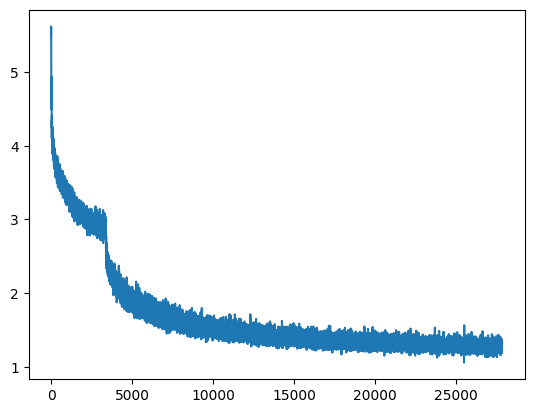

TRAIN TRUE: genre: powerpop, poprock, pop

TRAIN PRED-HF: <|endoftext|> rock; instrument: electricguitar, electricguitar, acousticguitar, bass, drums, 
electricguitar, electricguitar; mood/theme: melodic<|endoftext|>

TRAIN PRED-OUR: indie; instrument: bass, drums, acousticguitar, electricguitar, synthesizer, guitar<|endoftext|> 
acousticbassguitar, bass, sampler; mood/theme: advertising<|endoftext|> motivational<|endoftext|> summer, 
romantic<|endoftext|> happy<|endoftext|> christmas<|endoftext|> happy<|endoftext|> summer<|endoftext|> 
motivational<|endoftext|> game, positive<|endoftext|> happy<|endoftext|> energy

TEST TRUE: genre: folk; instrument: drums, keyboard, banjo

TEST PRED-HF: <|endoftext|> bass, electricguitar; mood/theme: melodic<|endoftext|>

TEST PRED-OUR: piano<|endoftext|>guitar, electricguitar<|endoftext|> electricbassguitar; mood/theme: 
ballad<|endoftext|> ballad<|endoftext|> love, folkrock, sexy, melodic<|endoftext|> soundscape, 
romantic<|endoftext|> romantic<|endoftext|> christmas<|endoftext|> melodic<|endoftext|><|endoftext|> 
adventure<|endoftext|><|endoftext|><|endoftext|>}, fun<|endoftext|><|endoftext|>}, 
honey<|endoftext|><|endoftext|><|endoftext|>

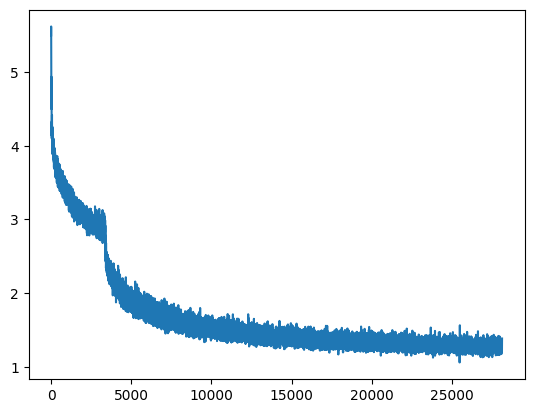

TRAIN TRUE: genre: electronic

TRAIN PRED-HF: <|endoftext|>, easylistening; instrument: synthesizer; mood/theme: energetic<|endoftext|>

TRAIN PRED-OUR: , reggae, jazz<|endoftext|>; instrument: piano, electricguitar, synthesizer, saxophone, drums, 
pipeorgan, electricpiano, keyboard<|endoftext|> drummachine, bass<|endoftext|> tubularbell, electricguitar, 
trumpet<|endoftext|> bass, synthesizer, drums, electricguitar<|endoftext|>, electricp

TEST TRUE: genre: ethno, latin, african; instrument: percussion; mood/theme: energetic, traditional

TEST PRED-HF: <|endoftext|> deep<|endoftext|>

TEST PRED-OUR: movie, deep, warm<|endoftext|> fast<|endoftext|> japan<|endoftext|>ward<|endoftext|><|endoftext|>, 
deep<|endoftext|>, 
travel<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|end
oftext|>, deep<|endoftext|><|endoftext|> 
holiday<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|en
doftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>}, 
deep<|endoftext|><|endoftext|> 
summer<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
theme<|endoftext|><|endoftext|><|endoftext|>

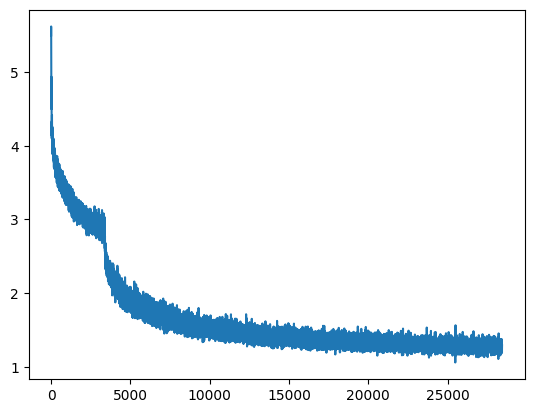

TRAIN TRUE: genre: electronic, easylistening

TRAIN PRED-HF: <|endoftext|> soundtrack; instrument: synthesizer; mood/theme: relaxing<|endoftext|>

TRAIN PRED-OUR: technohouse<|endoftext|>>, orchestral; instrument: keyboard, drummachine; mood/theme: 
film<|endoftext|> romantic, uplifting<|endoftext|>en<|endoftext|> 
anime<|endoftext|>ward<|endoftext|>ward<|endoftext|>ward<|endoftext|><|endoftext|>ward, 
video<|endoftext|><|endoftext|> fun<|endoftext|><|endoftext|> 
film<|endoftext|><|endoftext|>ward<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|e
ndoftext|>med<|endoftext|>, energetic<|endoftext|><|endoftext|>

TEST TRUE: genre: electronic, trance, ambient, lounge

TEST PRED-HF: <|endoftext|>; instrument: synthesizer, synthesizer; mood/theme: relaxing<|endoftext|>

TEST PRED-OUR: z; mood/theme: thank<|endoftext|>, uplifting<|endoftext|> 
energetic<|endoftext|><|endoftext|>ening<|endoftext|><|endoftext|>mark<|endoftext|> technomica, inspiring, 
fun<|endoftext|><|endoftext|> happy<|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
summer<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
love<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
drifting<|endoftext|><|endoftext|>ward<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|
><|endoftext|><|endoftext|><|endoftext|>ward<|endoftext|>are<|endoftext|>

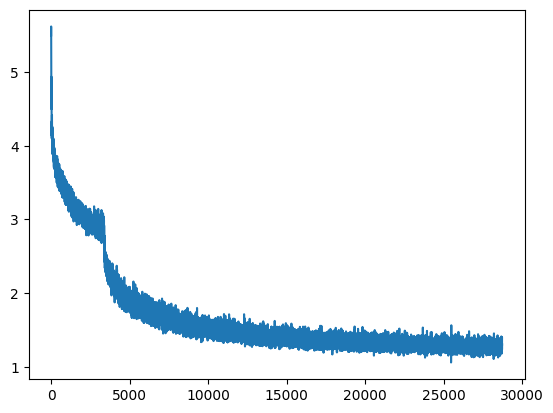

TRAIN TRUE: genre: electronic, experimental, soundtrack; mood/theme: ambiental

TRAIN PRED-HF: <|endoftext|> dream<|endoftext|>

TRAIN PRED-OUR: relaxing<|endoftext|> christmas, film, calm<|endoftext|> mysterious<|endoftext|> dream, 
environmental<|endoftext|> dream, quiet<|endoftext|> adventure, peaceful<|endoftext|> stern<|endoftext|> 
transparent<|endoftext|> commercial<|endoftext|> dynamic, future<|endoftext|> wicked<|endoftext|> 
technology<|endoftext|> sea<|endoftext|> relaxing<|endoftext|> summer, epic<|endoftext|> holiday<|endoftext|> 
project<|endoftext|> dream<|endoftext|> soundscape<|endoftext|> dream<|endoftext|>, school<|endoftext|> 
happy<|endoftext|> dark<|endoftext|> dream

TEST TRUE: genre: dance, techno, electronic; instrument: synthesizer, sampler; mood/theme: melodic

TEST PRED-HF: <|endoftext|> melodic<|endoftext|>

TEST PRED-OUR: france<|endoftext|> happy, bright<|endoftext|> bright, sour<|endoftext|> summer<|endoftext|>, 
energetic<|endoftext|> motivational<|endoftext|> summer<|endoftext|> dream<|endoftext|> reflective<|endoftext|> 
fun<|endoftext|> car<|endoftext|> film<|endoftext|> dream<|endoftext|><|endoftext|> 
commercial<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
summer<|endoftext|><|endoftext|><|endoftext|> commercial<|endoftext|><|endoftext|> and theme: 
powerful<|endoftext|><|endoftext|>, beach<|endoftext|> skav<|endoftext|> 
reflective<|endoftext|><|endoftext|><|endoftext|> holiday<|endoftext|>

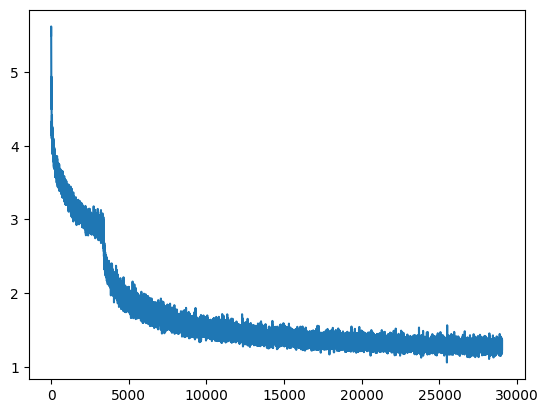

TRAIN TRUE: genre: electronic

TRAIN PRED-HF: <|endoftext|>, techno; mood/theme: energetic<|endoftext|>

TRAIN PRED-OUR: house, house, techno<|endoftext|>infotron; instrument: synthesizer, synthesizer, keyboard, 
pipeorgan, bass, computer<|endoftext|><|endoftext|><|endoftext|> drummachine, synthesizer<|endoftext|>mac, 
computer, keyboard; mood/theme: energetic<|endoftext|> married<|endoftext|> summer, summer<|endoftext|> 
summer<|endoftext|><|endoftext|>en<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>ward<|endoftext|
>

TEST TRUE: genre: experimental, 80s, electronic; instrument: synthesizer

TEST PRED-HF: <|endoftext|>>guitar, drums, bass, synthesizer; mood/theme: ambiental<|endoftext|>

TEST PRED-OUR: >, piano, synthesizer, drums, brass; mood/theme: melodic<|endoftext|> dark<|endoftext|> 
autumn<|endoftext|> warm, video<|endoftext|> deep<|endoftext|> soft<|endoftext|><|endoftext|>, epic, 
meditative<|endoftext|>, 
sad<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoft
ext|><|endoftext|><|endoftext|><|endoftext|>, 
nature<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|end
oftext|><|endoftext|><|endoftext|>

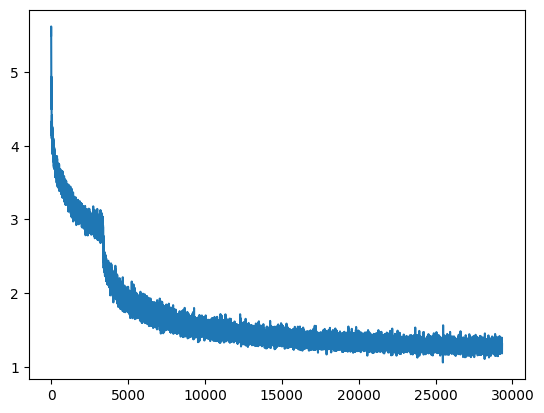

TRAIN TRUE: genre: ambient, classical, soundtrack; instrument: violin, cello, piano; mood/theme: adventure

TRAIN PRED-HF: <|endoftext|> film<|endoftext|>

TRAIN PRED-OUR: adventure, battle<|endoftext|> dramatic, horror, thriller<|endoftext|> epic<|endoftext|> 
silent<|endoftext|> action<|endoftext|> romantic<|endoftext|> corporate<|endoftext|> action<|endoftext|> 
movie<|endoftext|> adventure, menacing<|endoftext|> festive<|endoftext|> film<|endoftext|> summer, film, 
acoustic<|endoftext|> nostalgic<|endoftext|> adventure, joyful, wonder, video, sport, dark, trailer<|endoftext|> 
technop<|endoftext|> movie<|endoftext|> dream<|endoftext|> trailer<|endoftext|><|endoftext|>

TEST TRUE: genre: electronic

TEST PRED-HF: <|endoftext|>; instrument: synthesizer; mood/theme: energetic<|endoftext|>

TEST PRED-OUR: , pop, 20s; instrument: guitar, piano, electricguitar, synthesizer; mood/theme: driving<|endoftext|>
somatic<|endoftext|> film<|endoftext|> melodic<|endoftext|> dream, dark<|endoftext|> music, 
motivational<|endoftext|><|endoftext|><|endoftext|><|endoftext|> dream<|endoftext|> 
hopeful<|endoftext|><|endoftext|>, everyday<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
soundscape<|endoftext|>, uplifting<|endoftext|>

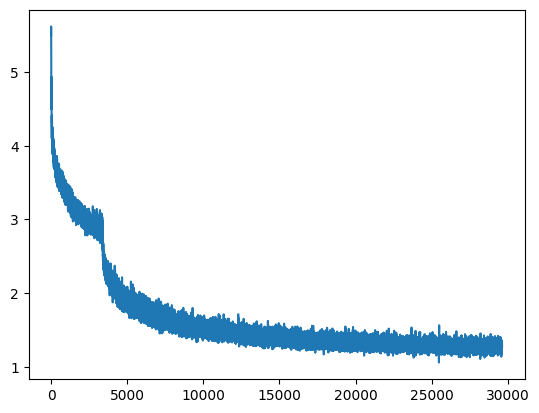

TRAIN TRUE: genre: instrumentalpop, lounge, easylistening

TRAIN PRED-HF: <|endoftext|> jazz; instrument: piano; mood/theme: energetic<|endoftext|>

TRAIN PRED-OUR: jazz, ambient<|endoftext|> ambient<|endoftext|> fusion<|endoftext|>ew; instrument: synthesizer, 
bass, electricguitar, soundscape, drums, classicalguitar, acousticguitar<|endoftext|> electricguitar, 
electricpiano, acousticbassguitar, acousticbassguitar, Billbell, bass, strings

TEST TRUE: genre: indie, folk

TEST PRED-HF: <|endoftext|>strument: acousticguitar, acousticguitar<|endoftext|>

TEST PRED-OUR: strument: harpsichord, pacica, acousticguitar<|endoftext|> piano<|endoftext|> cello, acousticguitar,
violin; mood/theme: commercial<|endoftext|> nature, commercial<|endoftext|> advertising<|endoftext|> 
advertising<|endoftext|> happy<|endoftext|> corporate<|endoftext|> advertising<|endoftext|> film, 
peaceful<|endoftext|> documentary<|endoftext|> romantic, happy<|endoftext|> romantic<|endoftext|> 
corporate<|endoftext|> interesting<|endoftext|> summer

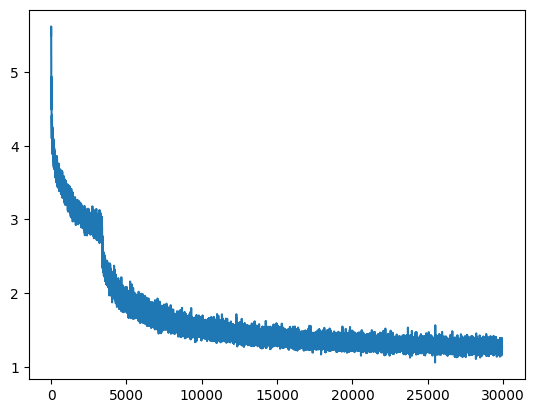

TRAIN TRUE: genre: electronic

TRAIN PRED-HF: <|endoftext|>, techno, techno; instrument: synthesizer, synthesizer; mood/theme: 
energetic<|endoftext|>

TRAIN PRED-OUR: clack, techno<|endoftext|>, electronic, ambient<|endoftext|> ---; mood/theme: urban<|endoftext|> 
summer<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|end
oftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
dancefloor<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
inspiring<|endoftext|><|endoftext|><|endoftext|><|endoftext|>ance<|endoftext|><|endoftext|><|endoftext|><|endoftext
|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endofte
xt|> themeant, relaxing

TEST TRUE: genre: pop, popfunk, funk; instrument: synthesizer, drums, voice, piano

TEST PRED-HF: <|endoftext|> bass, electricguitar, synthesizer; mood/theme: energetic<|endoftext|>

TEST PRED-OUR: guitar, acousticbassguitar; mood/theme: motivational, playful<|endoftext|> happy<|endoftext|> 
energetic<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>imensional<|endoftext|>, 
adventure<|endoftext|><|endoftext|>, 
energetic<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|
endoftext|><|endoftext|><|endoftext|><|endoftext|> 
summer<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
inspiring<|endoftext|><|endoftext|>ward<|endoftext|><|endoftext|><|endoftext|>

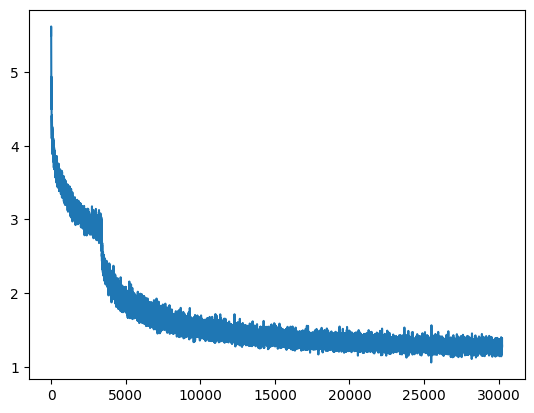

Unfroze gpt2


  0%|          | 0/3366 [00:00<?, ?it/s]

TRAIN TRUE: genre: poprock

TRAIN PRED-HF: <|endoftext|>>, electronic; instrument: synthesizer; mood/theme: melodic<|endoftext|>

TRAIN PRED-OUR: >, rock; instrument: piano, drums, bass, oboe<|endoftext|> stereo<|endoftext|> drums, 
electricguitar, electricguitar computer, electricguitar, keyboard, piano; mood/theme: fat<|endoftext|> 
melodic<|endoftext|><|endoftext|> concrete, emotional<|endoftext|><|endoftext|><|endoftext|><|endoftext|> summer, 
motivational<|endoftext|><|endoftext|><|endoftext|>,

TEST TRUE: genre: club, tribal, disco, dance, house; mood/theme: happy, summer

TEST PRED-HF: <|endoftext|> summer<|endoftext|>

TEST PRED-OUR: stupid, strange<|endoftext|> soundscape<|endoftext|> ballad<|endoftext|> music<|endoftext|> 
short<|endoftext|> at<|endoftext|><|endoftext|> fantasy<|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
happy<|endoftext|> summer<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
fantasy<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>lance<|endoftext|><|endoftext|><|endoftext|
>, tech<|endoftext|><|endoftext|> 
dark<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endof
text|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, j

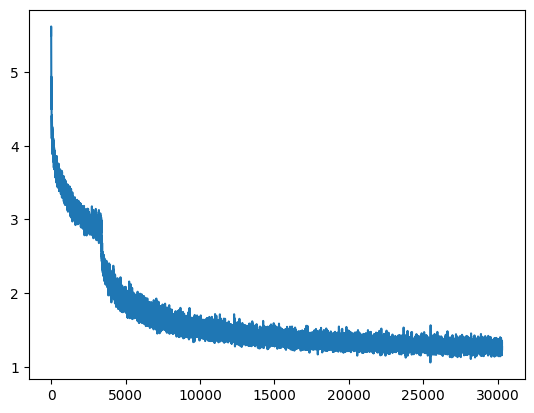

TRAIN TRUE: genre: soundtrack, electronic, house, ambient

TRAIN PRED-HF: <|endoftext|>; instrument: synthesizer, synthesizer; mood/theme: energetic<|endoftext|>

TRAIN PRED-OUR: <|endoftext|>beble; instrument: synthesizer, bass; mood/theme: politative<|endoftext|> dynamic, 
dynamic, melodic<|endoftext|> beautiful<|endoftext|> video<|endoftext|> summer, epic<|endoftext|>, 
christmas<|endoftext|> fun<|endoftext|><|endoftext|>, mellow<|endoftext|> 
beach<|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
summer<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, positive, holiday, 
love<|endoftext|><|endoftext|><|endoftext|>

TEST TRUE: genre: instrumentalrock, rock

TEST PRED-HF: <|endoftext|> rock; instrument: electricguitar, drums, bass, electricguitar, electricguitar; 
mood/theme: energetic<|endoftext|>

TEST PRED-OUR: bluesrock; instrument: bass<|endoftext|> piano<|endoftext|> guitar, drums, guitar, 
drums<|endoftext|> electricguitar, electricguitar, acousticguitar, standardorgan, voice, bass<|endoftext|> 
acousticguitar, electricguitar, drums<|endoftext|> percussion; mood/theme: sport<|endoftext|> dark<|endoftext|> 
film<|endoftext|> angry

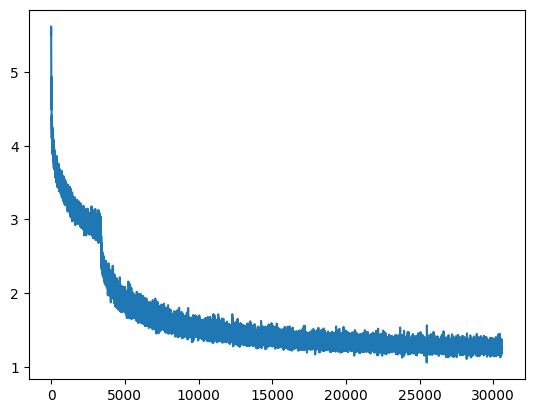

TRAIN TRUE: genre: soundtrack, indie, folk, pop; instrument: ukulele; mood/theme: dramatic, background, commercial,
film

TRAIN PRED-HF: <|endoftext|> motivational, corporate, corporate, corporate, advertising, corporate, corporate, 
corporate<|endoftext|>

TRAIN PRED-OUR: functional, trailer<|endoftext|> band, film<|endoftext|> trailer<|endoftext|> 
emotional<|endoftext|> happy<|endoftext|><|endoftext|><|endoftext|> optimistic<|endoftext|> soundscape, 
happy<|endoftext|> love<|endoftext|> party<|endoftext|> motivational<|endoftext|> comedy<|endoftext|> fun, 
evact<|endoftext|> classical<|endoftext|> melodic<|endoftext|> melodic<|endoftext|><|endoftext|> 
melodic<|endoftext|> intro<|endoftext|> dream<|endoftext|> dream<|endoftext|><|endoftext|> family<|endoftext|> 
summer<|endoftext|> commercial<|endoftext|><|endoftext|> theme:

TEST TRUE: genre: rock, rockfrancais; instrument: drums, electricguitar, bass

TEST PRED-HF: <|endoftext|> electricguitar, drums, electricguitar; mood/theme: energetic<|endoftext|>

TEST PRED-OUR: drums<|endoftext|> bass, electricguitar, electricguitar; mood/theme: france<|endoftext|> 
epic<|endoftext|> epic, love<|endoftext|> surprise<|endoftext|> motivational, galvanice, epic<|endoftext|> 
dark<|endoftext|> holiday, epic<|endoftext|> adventure, feminine<|endoftext|> long<|endoftext|> movie<|endoftext|> 
film<|endoftext|> action<|endoftext|> action<|endoftext|> motivational, ballad<|endoftext|> romantic<|endoftext|> 
sport

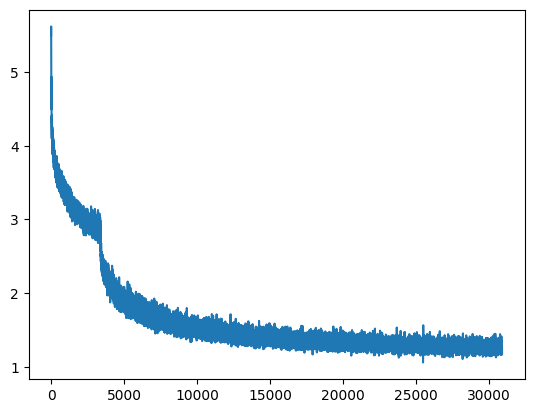

TRAIN TRUE: genre: electronic

TRAIN PRED-HF: <|endoftext|>strument: synthesizer; mood/theme: energetic<|endoftext|>

TRAIN PRED-OUR: m, pop<|endoftext|>; instrument: bass<|endoftext|> drums, electricguitar<|endoftext|> guitar, 
synthesizer; mood/theme: animation<|endoftext|> energetic<|endoftext|> deep<|endoftext|> dream<|endoftext|> dream, 
cynical<|endoftext|> summer<|endoftext|> way<|endoftext|> positive<|endoftext|><|endoftext|> holiday, 
action<|endoftext|><|endoftext|><|endoftext|>en<|endoftext|><|endoftext|> 
movie<|endoftext|><|endoftext|><|endoftext|>, happy, inspiring<|endoftext|><|endoftext|><|endoftext|>

TEST TRUE: genre: ambient, soundtrack, score; mood/theme: film, emotional

TEST PRED-HF: <|endoftext|> soundscape<|endoftext|>

TEST PRED-OUR: summer<|endoftext|> film<|endoftext|> dream<|endoftext|> psychological<|endoftext|> 
summer<|endoftext|> dream<|endoftext|> theme: exciting<|endoftext|> performance<|endoftext|> 
hopeful,video<|endoftext|> futuristic<|endoftext|> motivational, action, documentary<|endoftext|> motz<|endoftext|>
soundscape<|endoftext|> master<|endoftext|> film<|endoftext|> dream<|endoftext|> antica<|endoftext|> 
domic<|endoftext|><|endoftext|><|endoftext|> soundscape<|endoftext|> soundscape<|endoftext|> 
ambiental<|endoftext|><|endoftext|> summer<|endoftext|>cy<|endoftext|>

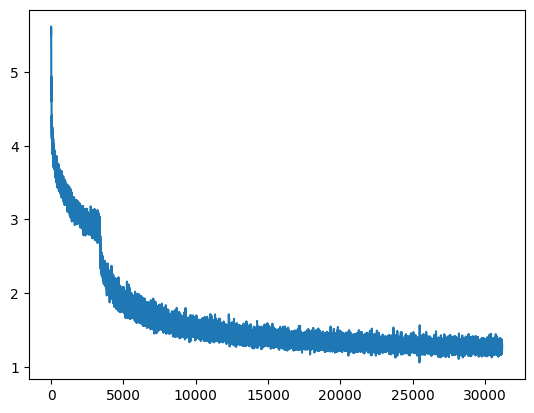

TRAIN TRUE: genre: alternative, experimental, electronic

TRAIN PRED-HF: <|endoftext|>; instrument: synthesizer; mood/theme: ambiental<|endoftext|>

TRAIN PRED-OUR: darkambient<|endoftext|> ambient, experimental, experimental, ambient; instrument: guitar; 
mood/theme: groovy<|endoftext|> hypnotic<|endoftext|> corporate<|endoftext|> music, love<|endoftext|> 
soundscape<|endoftext|> futuristic<|endoftext|> commercial<|endoftext|> dream<|endoftext|> soundscape<|endoftext|> 
positive<|endoftext|> soundscape<|endoftext|> dream, dream<|endoftext|> dream<|endoftext|> dream<|endoftext|> 
driving<|endoftext|> calm<|endoftext|> dream<|endoftext|> dream

TEST TRUE: genre: folk, jazzrock, chansonfrancaise, chanson, popfolk; instrument: electricguitar, saxophone, drums,
trombone, bass

TEST PRED-HF: <|endoftext|> electricguitar, acousticguitar, electricguitar, acousticguitar, acousticbassguitar, 
electricguitar; mood/theme: christmas<|endoftext|>

TEST PRED-OUR: electricpiano, acousticguitar, quinet, guitar<|endoftext|> guitar, flute, acousticguitar, 
electricguitar, piano, cello, bass, piano, rhodes, traditionalguitar, strings<|endoftext|> hongo, guitar, 
electricguitar, clarinet, clarinet

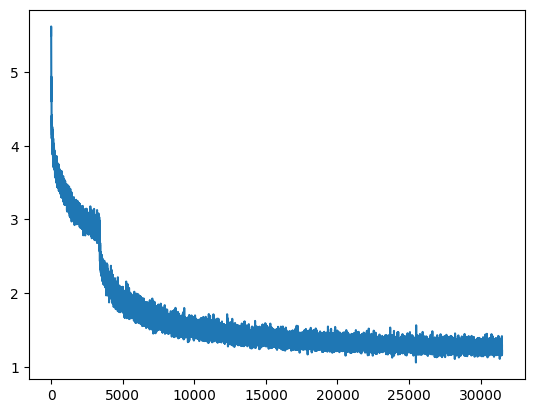

TRAIN TRUE: genre: rock, grunge

TRAIN PRED-HF: <|endoftext|>>rock; instrument: electricguitar, drums, bass, electricguitar, 
electricguitar<|endoftext|>

TRAIN PRED-OUR: nerggal<|endoftext|>strument: guitar, bass, electricguitar<|endoftext|> drums, bass, 
guitar<|endoftext|> electricguitar<|endoftext|> trombone<|endoftext|> bass<|endoftext|> guitar<|endoftext|> cymbal,
drummachine<|endoftext|> guitar, voice, guitar<|endoftext|> synthesizer<|endoftext|> drums, drums<|endoftext|> 
bass<|endoftext|> electricguitar, tinbassg

TEST TRUE: genre: ambient, soundtrack, electronic; instrument: piano; mood/theme: inspiring, emotional

TEST PRED-HF: <|endoftext|> soundscape<|endoftext|>

TEST PRED-OUR: celebr, festive, happy<|endoftext|> happy, romantic<|endoftext|> emotional<|endoftext|> love, 
corporate<|endoftext|> happy<|endoftext|><|endoftext|> inspiring<|endoftext|> soundscape<|endoftext|> education, 
classy<|endoftext|> romantic<|endoftext|> romantic<|endoftext|> dream, motivational<|endoftext|> 
documentary<|endoftext|> soundscape<|endoftext|><|endoftext|> family<|endoftext|> happy<|endoftext|> 
dream<|endoftext|> spark<|endoftext|> soundscape<|endoftext|> inspiring<|endoftext|> romantic<|endoftext|> 
dream<|endoftext|> dream, educational<|endoftext|> film

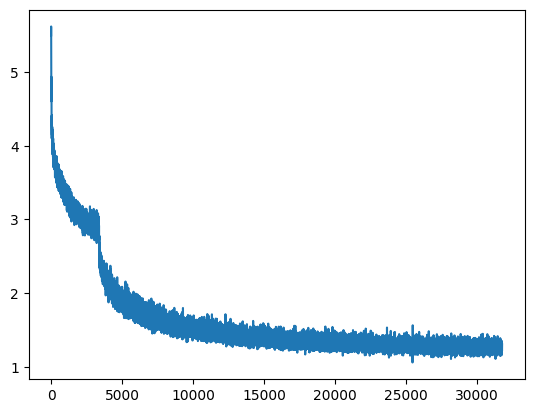

TRAIN TRUE: genre: instrumentalrock, rock, poprock; instrument: bass, electricguitar, drums, synthesizer; 
mood/theme: energetic, positive

TRAIN PRED-HF: <|endoftext|> happy, energetic<|endoftext|>

TRAIN PRED-OUR: graphics, inspiring, motivational, evontly<|endoftext|> motivating<|endoftext|> summer<|endoftext|>
motivational, energetic, happy, energetic<|endoftext|> corporate, energetic<|endoftext|><|endoftext|><|endoftext|>,
upbeat<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
energetic<|endoftext|><|endoftext|><|endoftext|> motivational<|endoftext|><|endoftext|>, 
background<|endoftext|><|endoftext|> commercial<|endoftext|><|endoftext|>, motivational<|endoftext|>, 
motivational<|endoftext|><|endoftext|><|endoftext|><|endoftext|> dream<|endoftext|><|endoftext|> deep<|endoftext|>

TEST TRUE: genre: metal, alternative, rock, instrumentalrock; instrument: bass, drummachine, electricguitar

TEST PRED-HF: <|endoftext|> drums, electricguitar, electricguitar; mood/theme: energetic<|endoftext|>

TEST PRED-OUR: electricguitar, drums<|endoftext|> electricguitar<|endoftext|> drums<|endoftext|> computer, 
computer, voice, drums, voice, electricguitar<|endoftext|> synthesizer<|endoftext|> computer<|endoftext|> 
guitar<|endoftext|> drums<|endoftext|> guitar, drums, keyboard<|endoftext|> synthesizer<|endoftext|> bass, drums, 
bass, bass, synthesizer<|endoftext|> electricguitar; mood

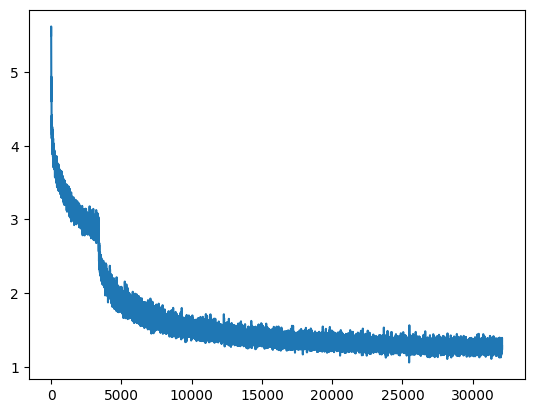

TRAIN TRUE: genre: easylistening, electronic, lounge; instrument: electricguitar, synthesizer, electricpiano; 
mood/theme: quiet, calm, soft

TRAIN PRED-HF: <|endoftext|> summer<|endoftext|>

TRAIN PRED-OUR: drama, uplifting<|endoftext|> relaxing, melancholy<|endoftext|> catchy<|endoftext|> 
energetic<|endoftext|> energetic<|endoftext|><|endoftext|> 
christmas<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
good<|endoftext|><|endoftext|> 
corporate<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
dream<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endo
ftext|><|endoftext|><|endoftext|>, 
meditative<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
soundscape<|endoftext|><|endoftext|>w<|endoftext|>

TEST TRUE: genre: world, house

TEST PRED-HF: <|endoftext|>; instrument: synthesizer; mood/theme: space<|endoftext|>

TEST PRED-OUR: ; instrument: piano; mood/theme: film, melancholic<|endoftext|>>, optimistic, ocean, uplifting, 
spiritual<|endoftext|> 
new<|endoftext|>><|endoftext|>><|endoftext|>><|endoftext|>><|endoftext|>jingle<|endoftext|>bright<|endoftext|><|end
oftext|><|endoftext|><|endoftext|>, sad<|endoftext|>bright<|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
holiday<|endoftext|><|endoftext|><|endoftext|>, 
christmas<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>hip

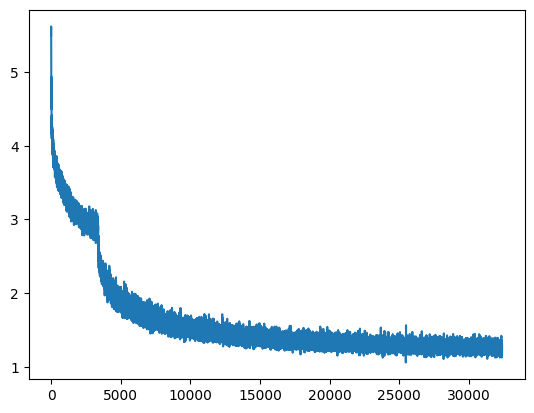

TRAIN TRUE: genre: rock; instrument: acousticguitar, bass, electricguitar, bongo, guiro, drums; mood/theme: upbeat

TRAIN PRED-HF: <|endoftext|> melodic<|endoftext|>

TRAIN PRED-OUR: melodic, positive, romantic<|endoftext|> documentary, playful, romantic<|endoftext|> 
dancing<|endoftext|> christmas<|endoftext|> love, game<|endoftext|> inspiring<|endoftext|> fun<|endoftext|> 
mexico<|endoftext|> commercial<|endoftext|><|endoftext|><|endoftext|> holiday<|endoftext|><|endoftext|> 
dream<|endoftext|><|endoftext|> documentary<|endoftext|> visual<|endoftext|> child<|endoftext|> wish<|endoftext|> 
wedding<|endoftext|> child<|endoftext|> dream<|endoftext|> television<|endoftext|> summer<|endoftext|> 
summer<|endoftext|><|endoftext|><|endoftext|> dream<|endoftext|>

TEST TRUE: genre: soundtrack, folk, popfolk; instrument: bass, electricguitar, acousticguitar, mandolin

TEST PRED-HF: <|endoftext|> piano; mood/theme: folkrock<|endoftext|>

TEST PRED-OUR: acousticguitar; mood/theme: sad, romantic<|endoftext|> romantic<|endoftext|> traditional, 
romantic<|endoftext|> holiday, sad<|endoftext|> romantic<|endoftext|> romantic<|endoftext|> adventure<|endoftext|> 
dream, emotional<|endoftext|> romantic<|endoftext|> emotional, inspirational, calm, dream<|endoftext|> 
happy<|endoftext|> brance<|endoftext|> happy<|endoftext|> holiday, calm<|endoftext|><|endoftext|> 
romantic<|endoftext|> dream<|endoftext|> holiday inspiring<|endoftext|> entertainment<|endoftext|>

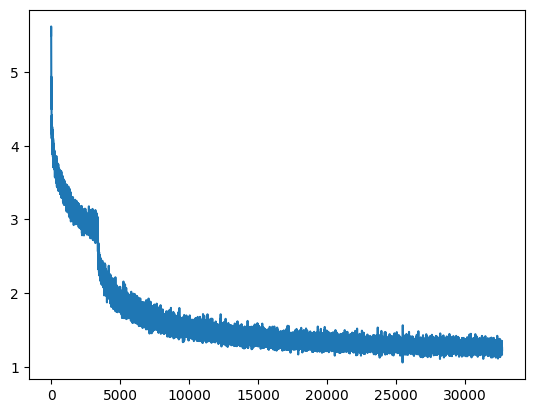

TRAIN TRUE: genre: alternativerock, soul, middleeastern; mood/theme: dark, indian

TRAIN PRED-HF: <|endoftext|> soundscape<|endoftext|>

TRAIN PRED-OUR: >, christmas<|endoftext|>>, happy<|endoftext|> japan<|endoftext|>jinquica<|endoftext|>, 
festive<|endoftext|> christmas<|endoftext|> wedding<|endoftext|> christmas<|endoftext|><|endoftext|> theme: 
epic<|endoftext|>able<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|e
ndoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> theme: 
sad<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
video<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>

TEST TRUE: genre: deephouse, progressive, electropop

TEST PRED-HF: <|endoftext|>beat, electronic; instrument: synthesizer; mood/theme: energetic<|endoftext|>

TEST PRED-OUR: beat, soundtrack; mood/theme: nermond<|endoftext|> rethereal<|endoftext|> motivational, 
golden<|endoftext|> fun, relaxing<|endoftext|><|endoftext|> sad<|endoftext|><|endoftext|>, dark<|endoftext|>, 
sad<|endoftext|><|endoftext|> hopeful<|endoftext|><|endoftext|><|endoftext|> dream<|endoftext|><|endoftext|> sun, 
dark<|endoftext|><|endoftext|><|endoftext|> dream<|endoftext|><|endoftext|> soundscape<|endoftext|><|endoftext|> 
summer, melodic<|endoftext|><|endoftext|>, melancholic<|endoftext|><|endoftext|>

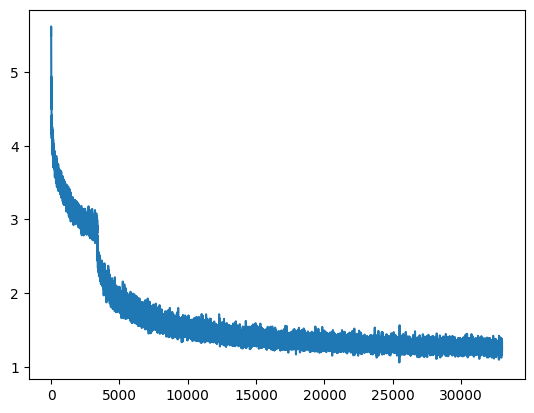

TRAIN TRUE: genre: rock, pop, world

TRAIN PRED-HF: <|endoftext|>; instrument: bass, drums, electricguitar; mood/theme: energetic<|endoftext|>

TRAIN PRED-OUR: rock<|endoftext|>, ska<|endoftext|>strument: drums; mood/theme: motivational<|endoftext|> 
happy<|endoftext|> summer<|endoftext|>, melodic<|endoftext|> soundscape<|endoftext|> 
playful<|endoftext|><|endoftext|><|endoftext|> dynamic<|endoftext|><|endoftext|>, theme: 
video<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
style<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endo
ftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|en
doftext|><|endoftext|><|endoftext|>

TEST TRUE: genre: electronic, soundtrack, ambient

TEST PRED-HF: <|endoftext|>; instrument: synthesizer; mood/theme: ambiental<|endoftext|>

TEST PRED-OUR: ; instrument: synthesizer; mood/theme: brazil<|endoftext|> movie, inspirational, 
entertainment<|endoftext|> summer, film, hard<|endoftext|>, nice<|endoftext|> 
TV<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endofte
xt|><|endoftext|>, spirited<|endoftext|><|endoftext|><|endoftext|> cool<|endoftext|><|endoftext|><|endoftext|>, 
france<|endoftext|>city<|endoftext|><|endoftext|><|endoftext|>, 
inspiring<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>

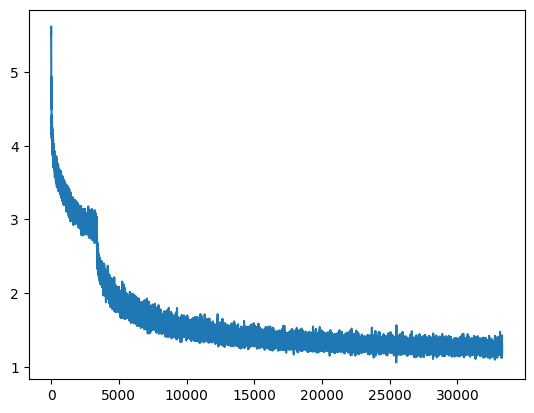

TRAIN TRUE: genre: soundtrack, classical, ambient; instrument: piano; mood/theme: film, emotional, epic

TRAIN PRED-HF: <|endoftext|> film<|endoftext|>

TRAIN PRED-OUR: film<|endoftext|> game, adventure<|endoftext|> trailer<|endoftext|> romantic, action, 
action<|endoftext|> dramatic<|endoftext|> documentary, epic<|endoftext|> commercial, emotional<|endoftext|> 
commercial, commercial, emotional<|endoftext|> adventure<|endoftext|> documentary<|endoftext|> 
action<|endoftext|><|endoftext|><|endoftext|> romance<|endoftext|> emotional<|endoftext|><|endoftext|> 
black<|endoftext|> big<|endoftext|><|endoftext|> romantic<|endoftext|> soundscape<|endoftext|> mystery<|endoftext|>
practical<|endoftext|> dream<|endoftext|> brazil<|endoftext|>, documentary

TEST TRUE: genre: easylistening

TEST PRED-HF: <|endoftext|>strument: synthesizer; mood/theme: relaxing<|endoftext|>

TEST PRED-OUR: jazz, reggae<|endoftext|> jazzjazz<|endoftext|> hiphop<|endoftext|> jazz; instrument: drummachine, 
synthesizer, acoustro, cello, drums, classicalguitar, trombone, cello, brass, saxophone, electricpiano, cello, 
hammond, tubularbell, bass,

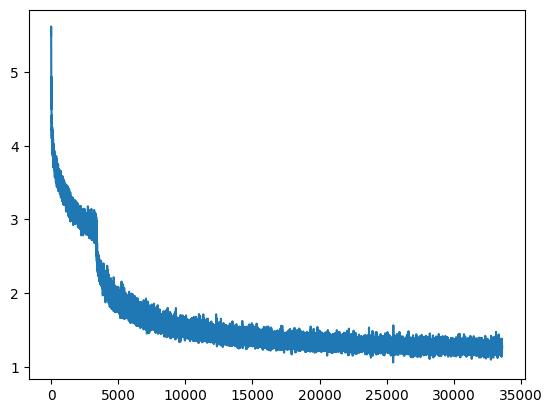

Unfroze gpt2


  0%|          | 0/3366 [00:00<?, ?it/s]

TRAIN TRUE: genre: electronic, soundtrack, glitch, techno; mood/theme: dark

TRAIN PRED-HF: <|endoftext|> dream<|endoftext|>

TRAIN PRED-OUR: <|endoftext|> dark, happy<|endoftext|> development, adventure, background<|endoftext|> 
corporate<|endoftext|> sexy<|endoftext|> powerful<|endoftext|><|endoftext|><|endoftext|> 
tech<|endoftext|><|endoftext|> inspiring<|endoftext|> tech<|endoftext|><|endoftext|><|endoftext|> 
tech<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endof
text|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, video<|endoftext|>, 
space<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
beautiful<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|
endoftext|>

TEST TRUE: genre: experimental, drone, ambient; instrument: rhodes, guitar

TEST PRED-HF: <|endoftext|> synthesizer; mood/theme: slow<|endoftext|>

TEST PRED-OUR: synthesizer; mood/theme: slow, dark, fast, social<|endoftext|> dream<|endoftext|> 
meditative<|endoftext|> dark<|endoftext|> reflective<|endoftext|> film<|endoftext|> calm<|endoftext|> 
soundscape<|endoftext|> calming<|endoftext|> soundscape<|endoftext|> fast<|endoftext|> dream<|endoftext|> relaxing,
video<|endoftext|> soundscape<|endoftext|> soundscape<|endoftext|> dark<|endoftext|> film<|endoftext|> 
dream<|endoftext|> dream<|endoftext|> technoo<|endoftext|> hypnotic<|endoftext|>

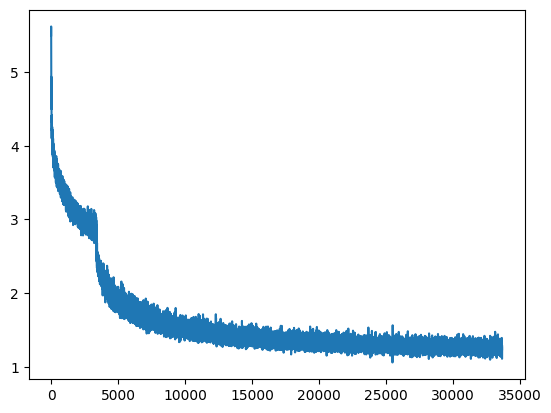

TRAIN TRUE: genre: industrial, electronic, experimental

TRAIN PRED-HF: <|endoftext|>; instrument: synthesizer; mood/theme: dark<|endoftext|>

TRAIN PRED-OUR: dance<|endoftext|>techno; instrument: synthesizer, bass, sampler<|endoftext|> 
synthesizer<|endoftext|> drummachine, electricguitar; mood/theme: action<|endoftext|> energetic, film<|endoftext|> 
soundscape<|endoftext|> deep<|endoftext|> dark<|endoftext|> happy<|endoftext|>joo<|endoftext|><|endoftext|> 
drummachine, slow<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
sport<|endoftext|>

TEST TRUE: genre: electronic, ambient

TEST PRED-HF: <|endoftext|>; instrument: synthesizer; mood/theme: ambiental<|endoftext|>

TEST PRED-OUR: triphop, chillout<|endoftext|> ambient; instrument: synthesizer<|endoftext|> choir, 
drums<|endoftext|> violin, bass, cymbal, flute, piano, electricpiano, clarinet, violin, doublebass; mood/theme: 
movies, melancholic, ambiental<|endoftext|> love<|endoftext|> medicine, energetic<|endoftext|> dream, deep

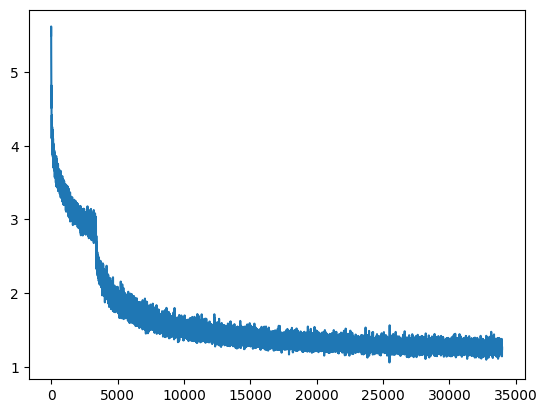

TRAIN TRUE: genre: chillout, ska, house; instrument: drums, synthesizer, keyboard, bass, percussion; mood/theme: 
deep, playful, summer

TRAIN PRED-HF: <|endoftext|> summer, playful<|endoftext|>

TRAIN PRED-OUR: brusky, energetic<|endoftext|> summer, sexy<|endoftext|> bright, 
motivational<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
energetic<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
summer<|endoftext|><|endoftext|><|endoftext|><|endoftext|>, 
playful<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
holiday<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|en
doftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>y<|endoftext|><
|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>

TEST TRUE: genre: classical; instrument: piano

TEST PRED-HF: <|endoftext|>>panflute<|endoftext|>

TEST PRED-OUR: >panflute, drums; mood/theme: love<|endoftext|> movie<|endoftext|> romantic, drama<|endoftext|> 
love, romantic<|endoftext|> happy, optimistic<|endoftext|> romantic, children<|endoftext|> romantic<|endoftext|> 
romantic<|endoftext|> dream<|endoftext|> romantic<|endoftext|> happy<|endoftext|>, romantic<|endoftext|> 
romantic<|endoftext|> inspirational<|endoftext|><|endoftext|><|endoftext|>, 
film<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endof
text|><|endoftext|><|endoftext|><|endoftext|>

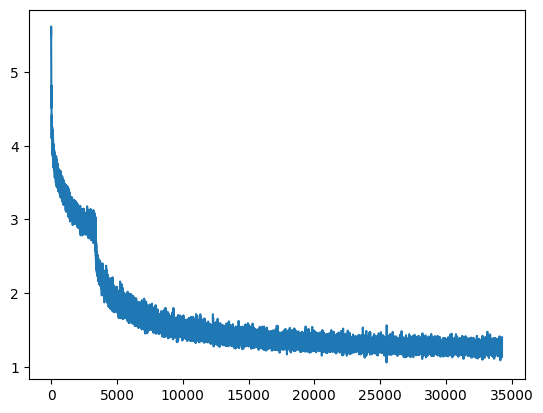

TRAIN TRUE: genre: soundtrack, world; instrument: percussion, bell

TRAIN PRED-HF: <|endoftext|> piano; mood/theme: documentary, film, film<|endoftext|>

TRAIN PRED-OUR: piano, bass<|endoftext|> voice, electricpiano, drums, unite, piano; mood/theme: ramving, movie, 
children, suspense<|endoftext|> sad, film<|endoftext|> her, driving<|endoftext|><|endoftext|> movie<|endoftext|> 
mother, cool, sweet<|endoftext|> commercial<|endoftext|> romantic<|endoftext|><|endoftext|> film<|endoftext|> 
beach<|endoftext|> corporate<|endoftext|> movie<|endoftext|> game<|endoftext|><|endoftext|><|endoftext|> film

TEST TRUE: genre: jazz; instrument: piano

TEST PRED-HF: <|endoftext|> guitar, electricguitar, drums, piano; mood/theme: melodic<|endoftext|>

TEST PRED-OUR: guitar, synthesizer<|endoftext|> drums, drums, tuba, bass, saxophone, flute, woodwind, drums, drums,
hammond, electricguitar, drums, violin, bass<|endoftext|> drummachine, bongo, electricguitar, bass<|endoftext|> 
tuba, bass, cello, classicalg

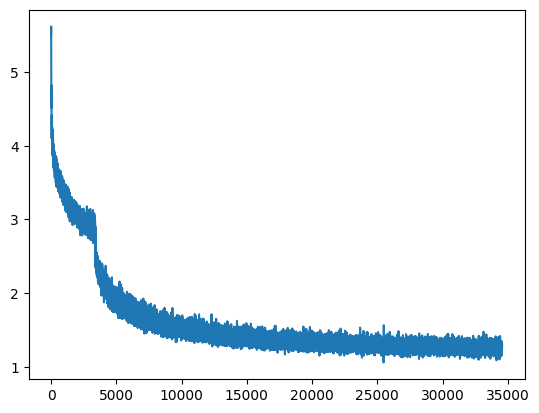

TRAIN TRUE: genre: soundtrack; instrument: guitar

TRAIN PRED-HF: <|endoftext|> piano; mood/theme: film<|endoftext|>

TRAIN PRED-OUR: <|endoftext|> drummachine, acousticguitar, acousticguitar, flute, doublebassguitar; mood/theme: 
nature, peaceful, peaceful<|endoftext|> dream<|endoftext|> happy<|endoftext|> motivational<|endoftext|> 
happy<|endoftext|> movie<|endoftext|> dream<|endoftext|> cute<|endoftext|>, happy<|endoftext|> 
philosophical<|endoftext|> movie<|endoftext|><|endoftext|> romantic<|endoftext|><|endoftext|> 
dynamic<|endoftext|>gaming<|endoftext|>, sentimental

TEST TRUE: genre: soundtrack, easylistening; mood/theme: beautiful, mellow

TEST PRED-HF: <|endoftext|> inspiring, motivational, uplifting, uplifting, uplifting, inspiring<|endoftext|>

TEST PRED-OUR: motivational, joyful, skational<|endoftext|> gender, meditative, action, nature<|endoftext|> 
commercial<|endoftext|> hopeful, romantic<|endoftext|> happy, inspiring<|endoftext|> inspirational<|endoftext|> and
happy<|endoftext|> comber<|endoftext|> inspirational<|endoftext|> brazil<|endoftext|> positive<|endoftext|> 
commercial<|endoftext|><|endoftext|> dream, motivational<|endoftext|><|endoftext|><|endoftext|>, inspiring, 
space<|endoftext|>, documentary<|endoftext|> love<|endoftext|> action<|endoftext|> sport<|endoftext|>

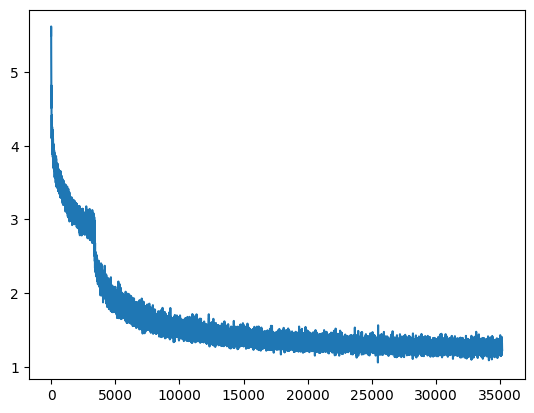

TRAIN TRUE: genre: folk, poprock, rock

TRAIN PRED-HF: <|endoftext|>; instrument: electricguitar; mood/theme: energetic<|endoftext|>

TRAIN PRED-OUR: ; instrument: piano<|endoftext|> synthesizer, bass, electricguitar, piano<|endoftext|> 
synthesizer<|endoftext|> ballad, acousticguitar<|endoftext|> electricguitar<|endoftext|> cello, trumpet, hammond, 
trombone<|endoftext|> violin, electricpiano, trumpet, flute, clarinet, bass, drums, acoustic

TEST TRUE: genre: world, newage, folk, orchestral; mood/theme: meditative

TEST PRED-HF: <|endoftext|> soundscape<|endoftext|>

TEST PRED-OUR: feel, ambiental<|endoftext|> dream, meditative, positive<|endoftext|> action<|endoftext|> 
dream<|endoftext|> romantic<|endoftext|> sweet<|endoftext|> adventure<|endoftext|> dream<|endoftext|> 
deep<|endoftext|> dream<|endoftext|> inspiring<|endoftext|> dream<|endoftext|> holiday<|endoftext|><|endoftext|> 
happy<|endoftext|> dream<|endoftext|><|endoftext|><|endoftext|> happy<|endoftext|> 
dream<|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
industrial<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>l
inger<|endoftext|><|endoftext|> dream<|endoftext|><|endoftext|>

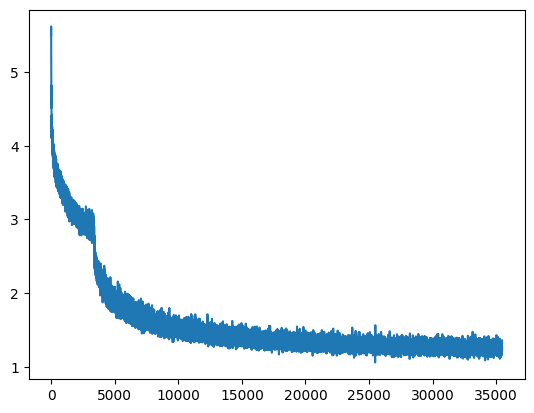

TRAIN TRUE: genre: jazz; instrument: electricguitar, bass, piano, drums

TRAIN PRED-HF: <|endoftext|> piano; mood/theme: happy, happy, happy, happy<|endoftext|>

TRAIN PRED-OUR: strings<|endoftext|> guitar<|endoftext|> piano, piano<|endoftext|> acousticguitar, 
doublebassguitar, drums, piano, bass, saxophone, trombone, electricpiano, electricpiano, classicalguitar, 
bass<|endoftext|> strings, doublebassguitar; mood/theme: love<|endoftext|><|endoftext|> holiday<|endoftext|>

TEST TRUE: genre: popfolk, pop

TEST PRED-HF: <|endoftext|>>; instrument: acousticguitar, acousticguitar, electricguitar, acousticguitar, 
acousticguitar, acousticguitar; mood/theme: melodic<|endoftext|>

TEST PRED-OUR: >; instrument: strings, guitar, violin, electricguitar, cabasa, saxophone, drums, acousticguitar, 
piano<|endoftext|> bass, electricpiano, electricguitar, bass, classicalguitar, acousticguitar; mood/theme: 
romantic<|endoftext|> happy<|endoftext|> cheerful, modern

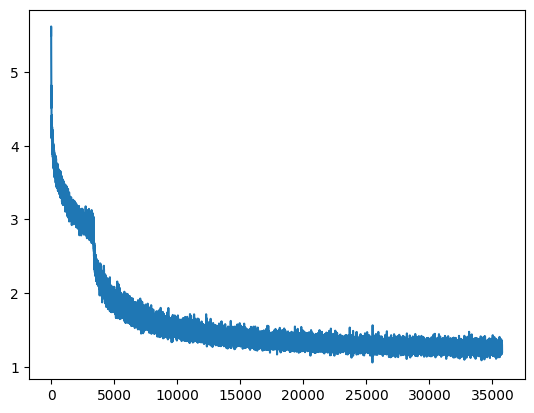

TRAIN TRUE: genre: ambient, chillout, lounge; mood/theme: relaxing

TRAIN PRED-HF: <|endoftext|> soundscape<|endoftext|>

TRAIN PRED-OUR: soundscape<|endoftext|> float, magic<|endoftext|> playful<|endoftext|> dream<|endoftext|> dream, 
background, brance<|endoftext|> love<|endoftext|><|endoftext|> dream<|endoftext|> learning, calm<|endoftext|> 
chillout<|endoftext|> dream<|endoftext|> dream<|endoftext|> soundscape<|endoftext|><|endoftext|>, playful, 
motivational<|endoftext|> relaxing, global<|endoftext|> 
spacient<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|e
ndoftext|>indoo<|endoftext|>idoo<|endoftext|>

TEST TRUE: genre: downtempo, chillout; instrument: piano; mood/theme: uplifting, chilled

TEST PRED-HF: <|endoftext|> happy<|endoftext|>

TEST PRED-OUR: bright, energetic, dream<|endoftext|> fun<|endoftext|> reflective<|endoftext|> cool<|endoftext|> 
adventure<|endoftext|> happy<|endoftext|><|endoftext|> 
love<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> school<|endoftext|> 
summer<|endoftext|><|endoftext|><|endoftext|><|endoftext|>lounge<|endoftext|>ward<|endoftext|> 
relaxing<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|e
ndoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>s
tream<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>mas<|endoftext|><|e
ndoftext|>

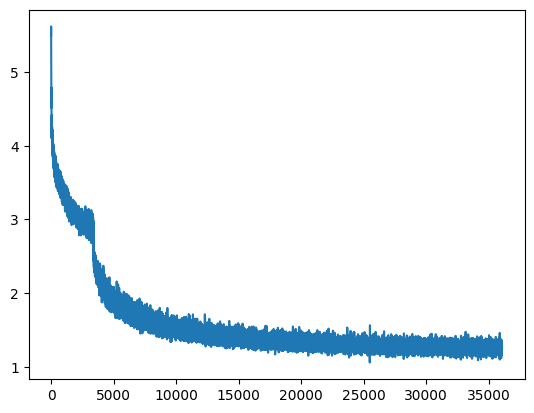

TRAIN TRUE: genre: experimental, chillout, hiphop, electronic; instrument: bass, synthesizer, drummachine, drums, 
rhodes, cvp509; mood/theme: upbeat

TRAIN PRED-HF: <|endoftext|> soundscape<|endoftext|>

TRAIN PRED-OUR: cool<|endoftext|> melodic, strong, reflective, energetic, dark<|endoftext|> 
summer<|endoftext|><|endoftext|><|endoftext|>, sad<|endoftext|> romantic<|endoftext|>, dark<|endoftext|>, 
joyful<|endoftext|> summer, dark, deep<|endoftext|> inspirational, love<|endoftext|><|endoftext|> summer, 
deep<|endoftext|><|endoftext|> romantic<|endoftext|><|endoftext|>, 
peaceful<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> summer<|endoftext|> 
drama<|endoftext|><|endoftext|><|endoftext|><|endoftext|> happy<|endoftext|><|endoftext|>

TEST TRUE: genre: house, downtempo, electronic

TEST PRED-HF: <|endoftext|>; instrument: piano; mood/theme: meditative<|endoftext|>

TEST PRED-OUR: ; instrument: guitar, piano<|endoftext|> keyboard, acousticguitar, drums, pipeorgan, 
doublebassguitar, violin, keyboard, trumpet; mood/theme: upbeat, mysterious, adventure<|endoftext|><|endoftext|> 
movie<|endoftext|> movie<|endoftext|><|endoftext|> fun<|endoftext|> summer, brazil, motivational, 
holiday<|endoftext|>, emotional<|endoftext|>, inspirational,

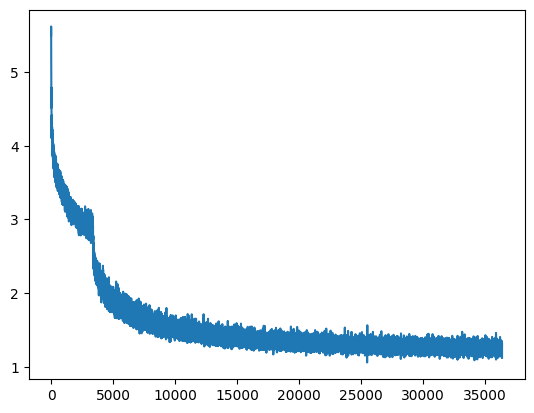

KeyboardInterrupt: 

In [21]:
for epoch in tqdm(range(num_epochs)):
    
    if epoch >= 1:
        print('Unfroze gpt2')
        for pg in opt.param_groups[1:]:
            pg['lr'] = 0.1*5e-5
    
    for step, (caption_batch, embedding_batch) in enumerate(tqdm(train_dataloader)):
        # tokenize and prepare inputs for forward
        input_ids, input_ids_target = tokenize(caption_batch)
        inputs_embeds, input_ids_target = transform_input_ids(
            embedding_batch,
            input_ids,
            input_ids_target
        )
        
        losses.append(update_step(inputs_embeds, input_ids_target))
        
        if step % 300 == 0:
            eval_step()
            plt.plot(losses)
            plt.show()

In [ ]:
caption_batch, embedding_batch = next(iter(eval_test_dataloader))
pred = eval(caption_batch, embedding_batch, use_manual_generation=True)
printr('[green bold]TEST TRUE: ' + caption_batch[0])
printr('[blue]TEST PRED-A: ' + pred[0])

In [29]:
gps = dict(
    max_length=64,
    num_beams=4,
    do_sample=True,
    temperature=1,
    pad_token_id=mask_id,
    use_manual_generation=False
)

_ = dict(
    max_length=64,
    iters=16,
    do_sample=True,
    use_manual_generation=True
)

In [30]:
caption_batch, embedding_batch = next(iter(eval_test_dataloader))
pred = eval(caption_batch, embedding_batch, **gps)
printr('[green bold]TRAIN TRUE: ' + caption_batch[0])
printr('[blue]TRAIN PRED-HF: ' + pred[0])

TRAIN TRUE: genre: electroambient, newage, electronic; instrument: synthesizer

TRAIN PRED-HF: <|endoftext|> drummachine, synthesizer; mood/theme: ambiental<|endoftext|>